In [1]:
import csv
import matplotlib.pyplot as plt

import xarray as xr

import pandas as pd
import json

import numpy as np
import seaborn as sns
import datetime as datetime
from netCDF4 import num2date, date2num

# Reading classification csv file from zooniverse

In [2]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [3]:
### Functions from https://github.com/zooniverse/Data-digging/blob/master/example_scripts/astronomy_rewind/workflow1to2.py

def JSONParser(data):
    """call json.loads"""
    return json.loads(data)


def load_classifications(filename, json_columns=None):
    """
    Load classifications into pandas dataframe.
    Some columns of the csv are embedded json and need special parsing.
    """
    json_columns = json_columns or ['metadata', 'annotations', 'subject_data']
    converters = {i: JSONParser for i in json_columns}

    return pd.read_csv(filename, converters=converters)

def unpack(series):
    """
    Return the first value in a series.
    All annotations values are lists because of a few multiple tasks.
    The second multiple task always has the value of 'None of the above'
    (For this dataset!)
    """
    return [a[0] for a in series]


def parse_classifications(filename,**kwarg):
    """
    Load classifications and datamunge annotations column.
    """
    data = load_classifications(filename,**kwarg)

    # Only need the first item in the annotations list of json objects
    data['annotations'] = unpack(data['annotations'])
    return data

In [4]:
def get_time_spent(obj):
    from datetime import timedelta, datetime
    time_fmt='%Y-%m-%dT%H:%M:%S.%fZ'
    start=datetime.strptime(obj[11]['started_at'],time_fmt)
    stop=datetime.strptime(obj[11]['finished_at'],time_fmt)
    d=stop-start
    if d.total_seconds() > 3600*10:
        d=0
        return d
    else:
        return d.total_seconds()

In [5]:
classification_data = parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']); classification_data.tail()

classification_id user_name    user_id               user_ip  \
34611          136647387     onnoq  1834851.0  af96bca21f888f9ee82c   
34612          136647412     onnoq  1834851.0  af96bca21f888f9ee82c   
34613          136647449     onnoq  1834851.0  af96bca21f888f9ee82c   
34614          136647469     onnoq  1834851.0  af96bca21f888f9ee82c   
34615          136647512     onnoq  1834851.0  af96bca21f888f9ee82c   

       workflow_id workflow_name  workflow_version               created_at  \
34611         8073  Full dataset             13.11  2018-12-14 16:09:42 UTC   
34612         8073  Full dataset             13.11  2018-12-14 16:09:54 UTC   
34613         8073  Full dataset             13.11  2018-12-14 16:10:08 UTC   
34614         8073  Full dataset             13.11  2018-12-14 16:10:14 UTC   
34615         8073  Full dataset             13.11  2018-12-14 16:10:28 UTC   

       gold_standard  expert  \
34611            NaN     NaN   
34612            NaN     NaN   
34613            NaN     NaN   
34614            NaN     NaN   
34615            NaN     NaN   

                                                metadata  \
34611  {'source': 'api', 'session': '67f9a58fcd31b031...   
34612  {'source': 'api', 'session': '67f9a58fcd31b031...   
34613  {'source': 'api', 'session': '67f9a58fcd31b031...   
34614  {'source': 'api', 'session': '67f9a58fcd31b031...   
34615  {'source': 'api', 'session': '67f9a58fcd31b031...   

                                             annotations  \
34611  {'task': 'T0', 'task_label': 'Draw bounding bo...   
34612  {'task': 'T0', 'task_label': 'Draw bounding bo...   
34613  {'task': 'T0', 'task_label': 'Draw bounding bo...   
34614  {'task': 'T0', 'task_label': 'Draw bounding bo...   
34615  {'task': 'T0', 'task_label': 'Draw bounding bo...   

                                            subject_data  subject_ids  
34611  {'27142706': {'retired': None, 'fn': '/project...     27142706  
34612  {'27144789': {'retired': None, 'fn': '/project...     27144789  
34613  {'27163862': {'retired': None, 'fn': '/project...     27163862  
34614  {'27143251': {'retired': {'id': 24671973, 'wor...     27143251  
34615  {'27147693': {'retired': None, 'fn': '/project...     27147693

In [6]:
classification_data["created_at"] = [datetime.datetime.strptime(classification_data.created_at[i], "%Y-%m-%d %H:%M:%S UTC") for i in classification_data.index]

In [7]:
# Get first index of data after specific date
ind = np.min(np.where(classification_data.created_at > datetime.datetime(2018,10,2))[0]); ind
classification_data = classification_data.iloc[ind:]

In [8]:
classification_data.annotations[classification_data.index[0]]

{'task': 'T0',
 'task_label': 'Draw bounding boxes around cloud regions',
 'value': [{'x': 1025.257080078125,
   'y': 432.2316589355469,
   'tool': 0,
   'frame': 0,
   'width': 389.17626953125,
   'height': 371.2830505371094,
   'details': [],
   'tool_label': 'Sugar'}]}

In [9]:
classification_data.metadata[classification_data.index[0]]

{'source': 'api',
 'session': '88559898111399b0c5d554bebfa330e9829a65ebfb9485540a077ea3aecbb3cf',
 'viewport': {'width': 960, 'height': 977},
 'started_at': '2018-10-24T17:02:41.342Z',
 'user_agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
 'utc_offset': '-7200',
 'finished_at': '2018-10-24T17:02:45.495Z',
 'live_project': False,
 'interventions': {'opt_in': True, 'message': False},
 'user_language': 'en',
 'user_group_ids': [],
 'subject_dimensions': [{'clientWidth': 469,
   'clientHeight': 313,
   'naturalWidth': 2100,
   'naturalHeight': 1400}]}

In [10]:
# Get time spend on each classification
classification_data['time_spent'] = [get_time_spent(row) for row in classification_data.itertuples()]

# User statistics

In [11]:
def update_user_dict(user_dic,user_id, dic):
    # user existiert bereits
    if user_dic.get(user_id) != None:
        for key in dic.keys():
            if user_dic[user_id].get(key) != None:
                old_value = user_dic[user_id][key]
                new_value = old_value+dic[key]
                user_dic[user_id][key]=new_value
            else:
                user_dic[user_id][key]=dic[key]
    else:
        user_dic[user_id] = dic
    return user_dic

In [12]:
user_stat = {}
for u,user_classifications in classification_data.groupby('user_name'):
    pattern_types = user_classifications.annotations
    labels=np.array([])
    for classification in pattern_types:
        labels = np.append(labels,[value['tool'] for value in classification['value']])
    [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels.astype(int),minlength=4)
    time_spent = user_classifications.time_spent.sum()
    user_stat = update_user_dict(user_stat, u, {'images_seen': len(user_classifications), 'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar, 'time_spent': time_spent})

In [13]:
DF_user = pd.DataFrame.from_dict(user_stat,orient='index')
DF_user['labels_done'] = DF_user.iloc[:,[1,2,3,4]].sum(axis=1)
DF_user.sort_values('labels_done',inplace=True)
DF_user.head()
DF_user.drop(DF_user.index[DF_user.labels_done < 200],inplace=True)

<Figure size 432x288 with 0 Axes>

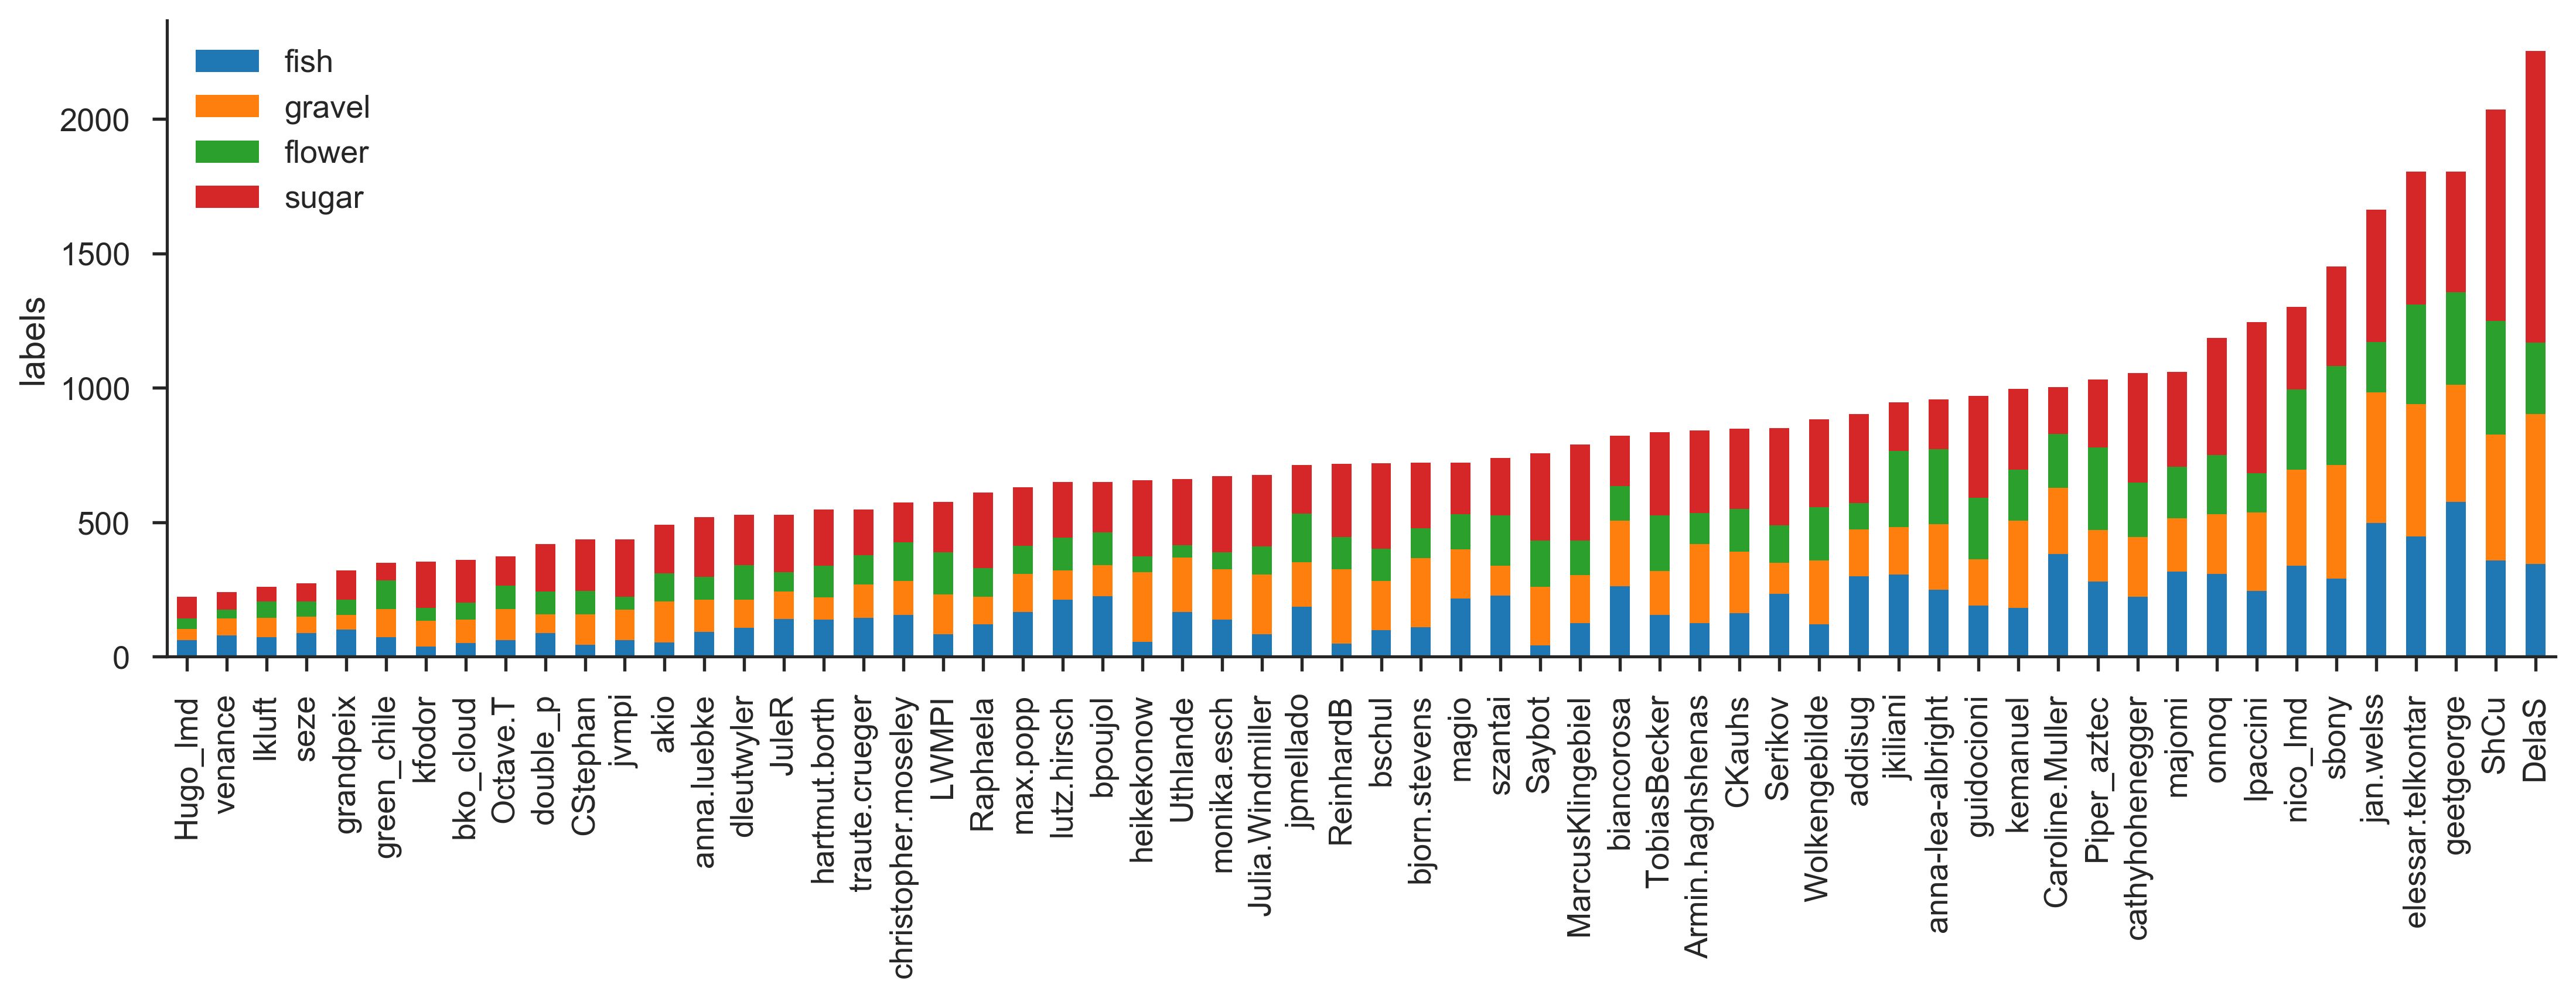

In [15]:
sns.set_context('talk')
sns.set_style('ticks')
fig=plt.figure()
p1=(DF_user.iloc[:,[1,2,3,4]]).plot(kind='bar', figsize=(15,6), stacked=True)#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
p1.set_ylabel('labels')
#plt.hlines(500,-1,70)
sns.despine()
plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('/Users/haukeschulz/Desktop/CloudClassificationDayStats_preliminary.png',transparent=True);

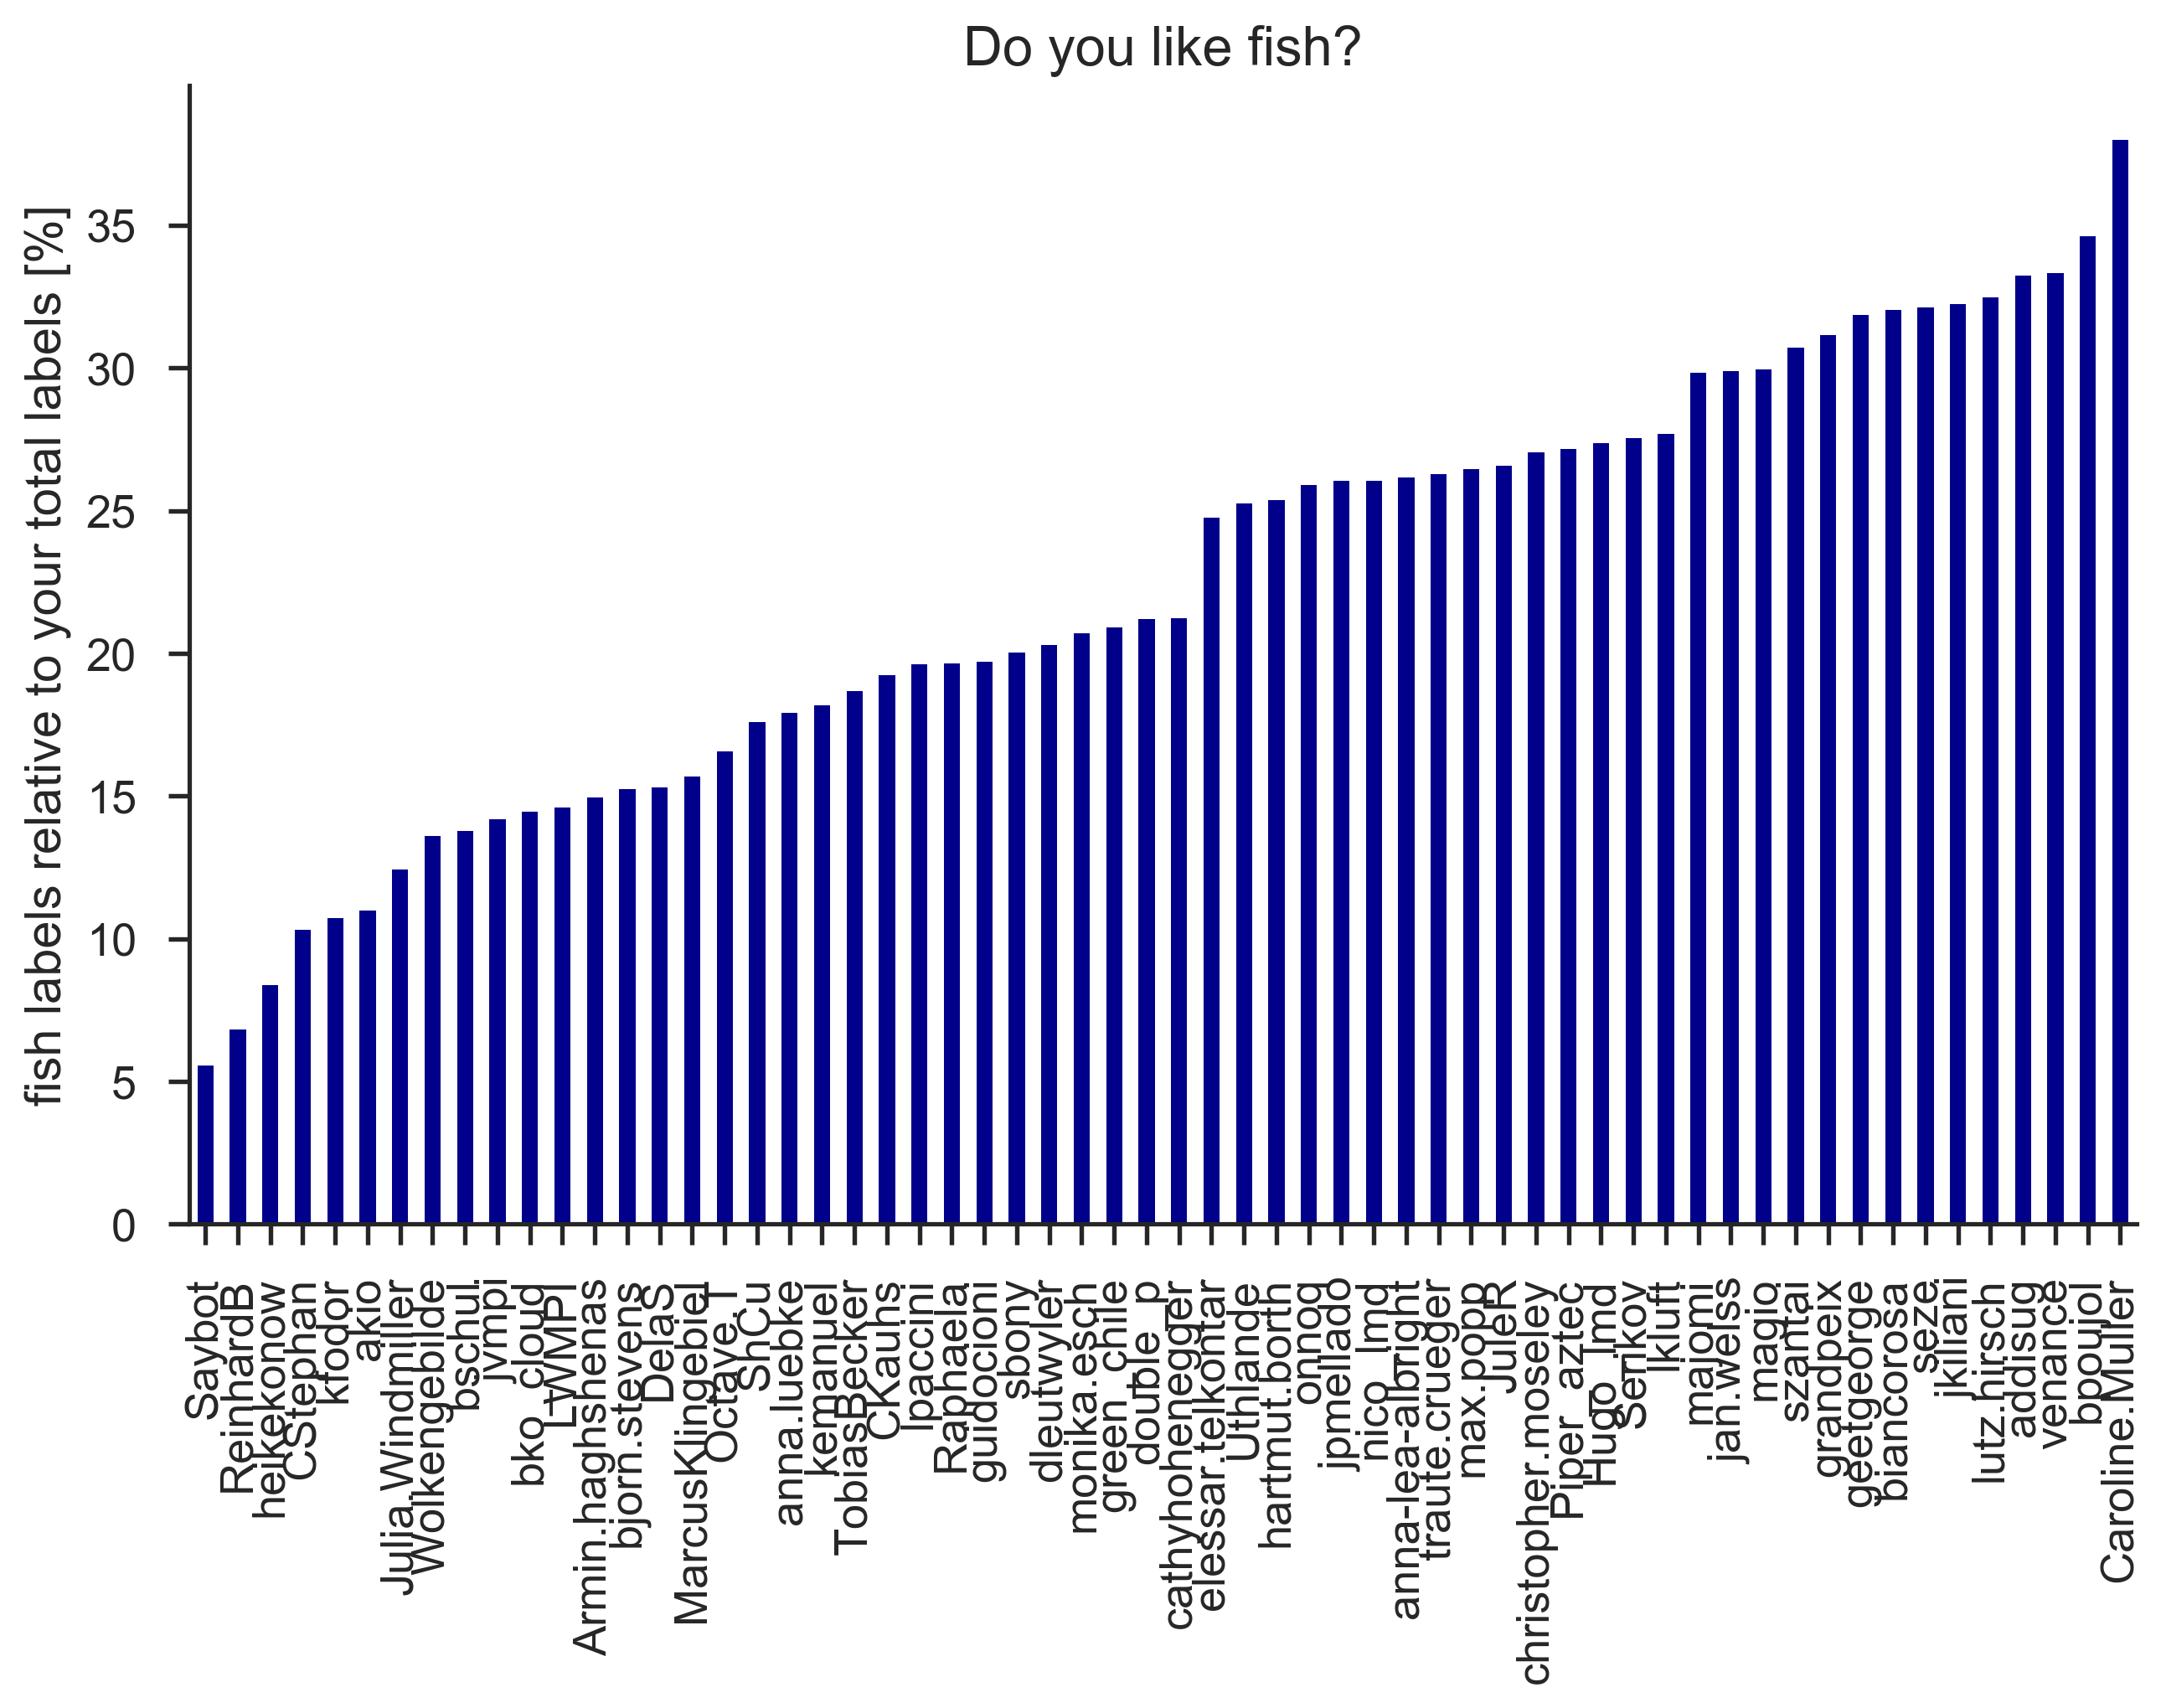

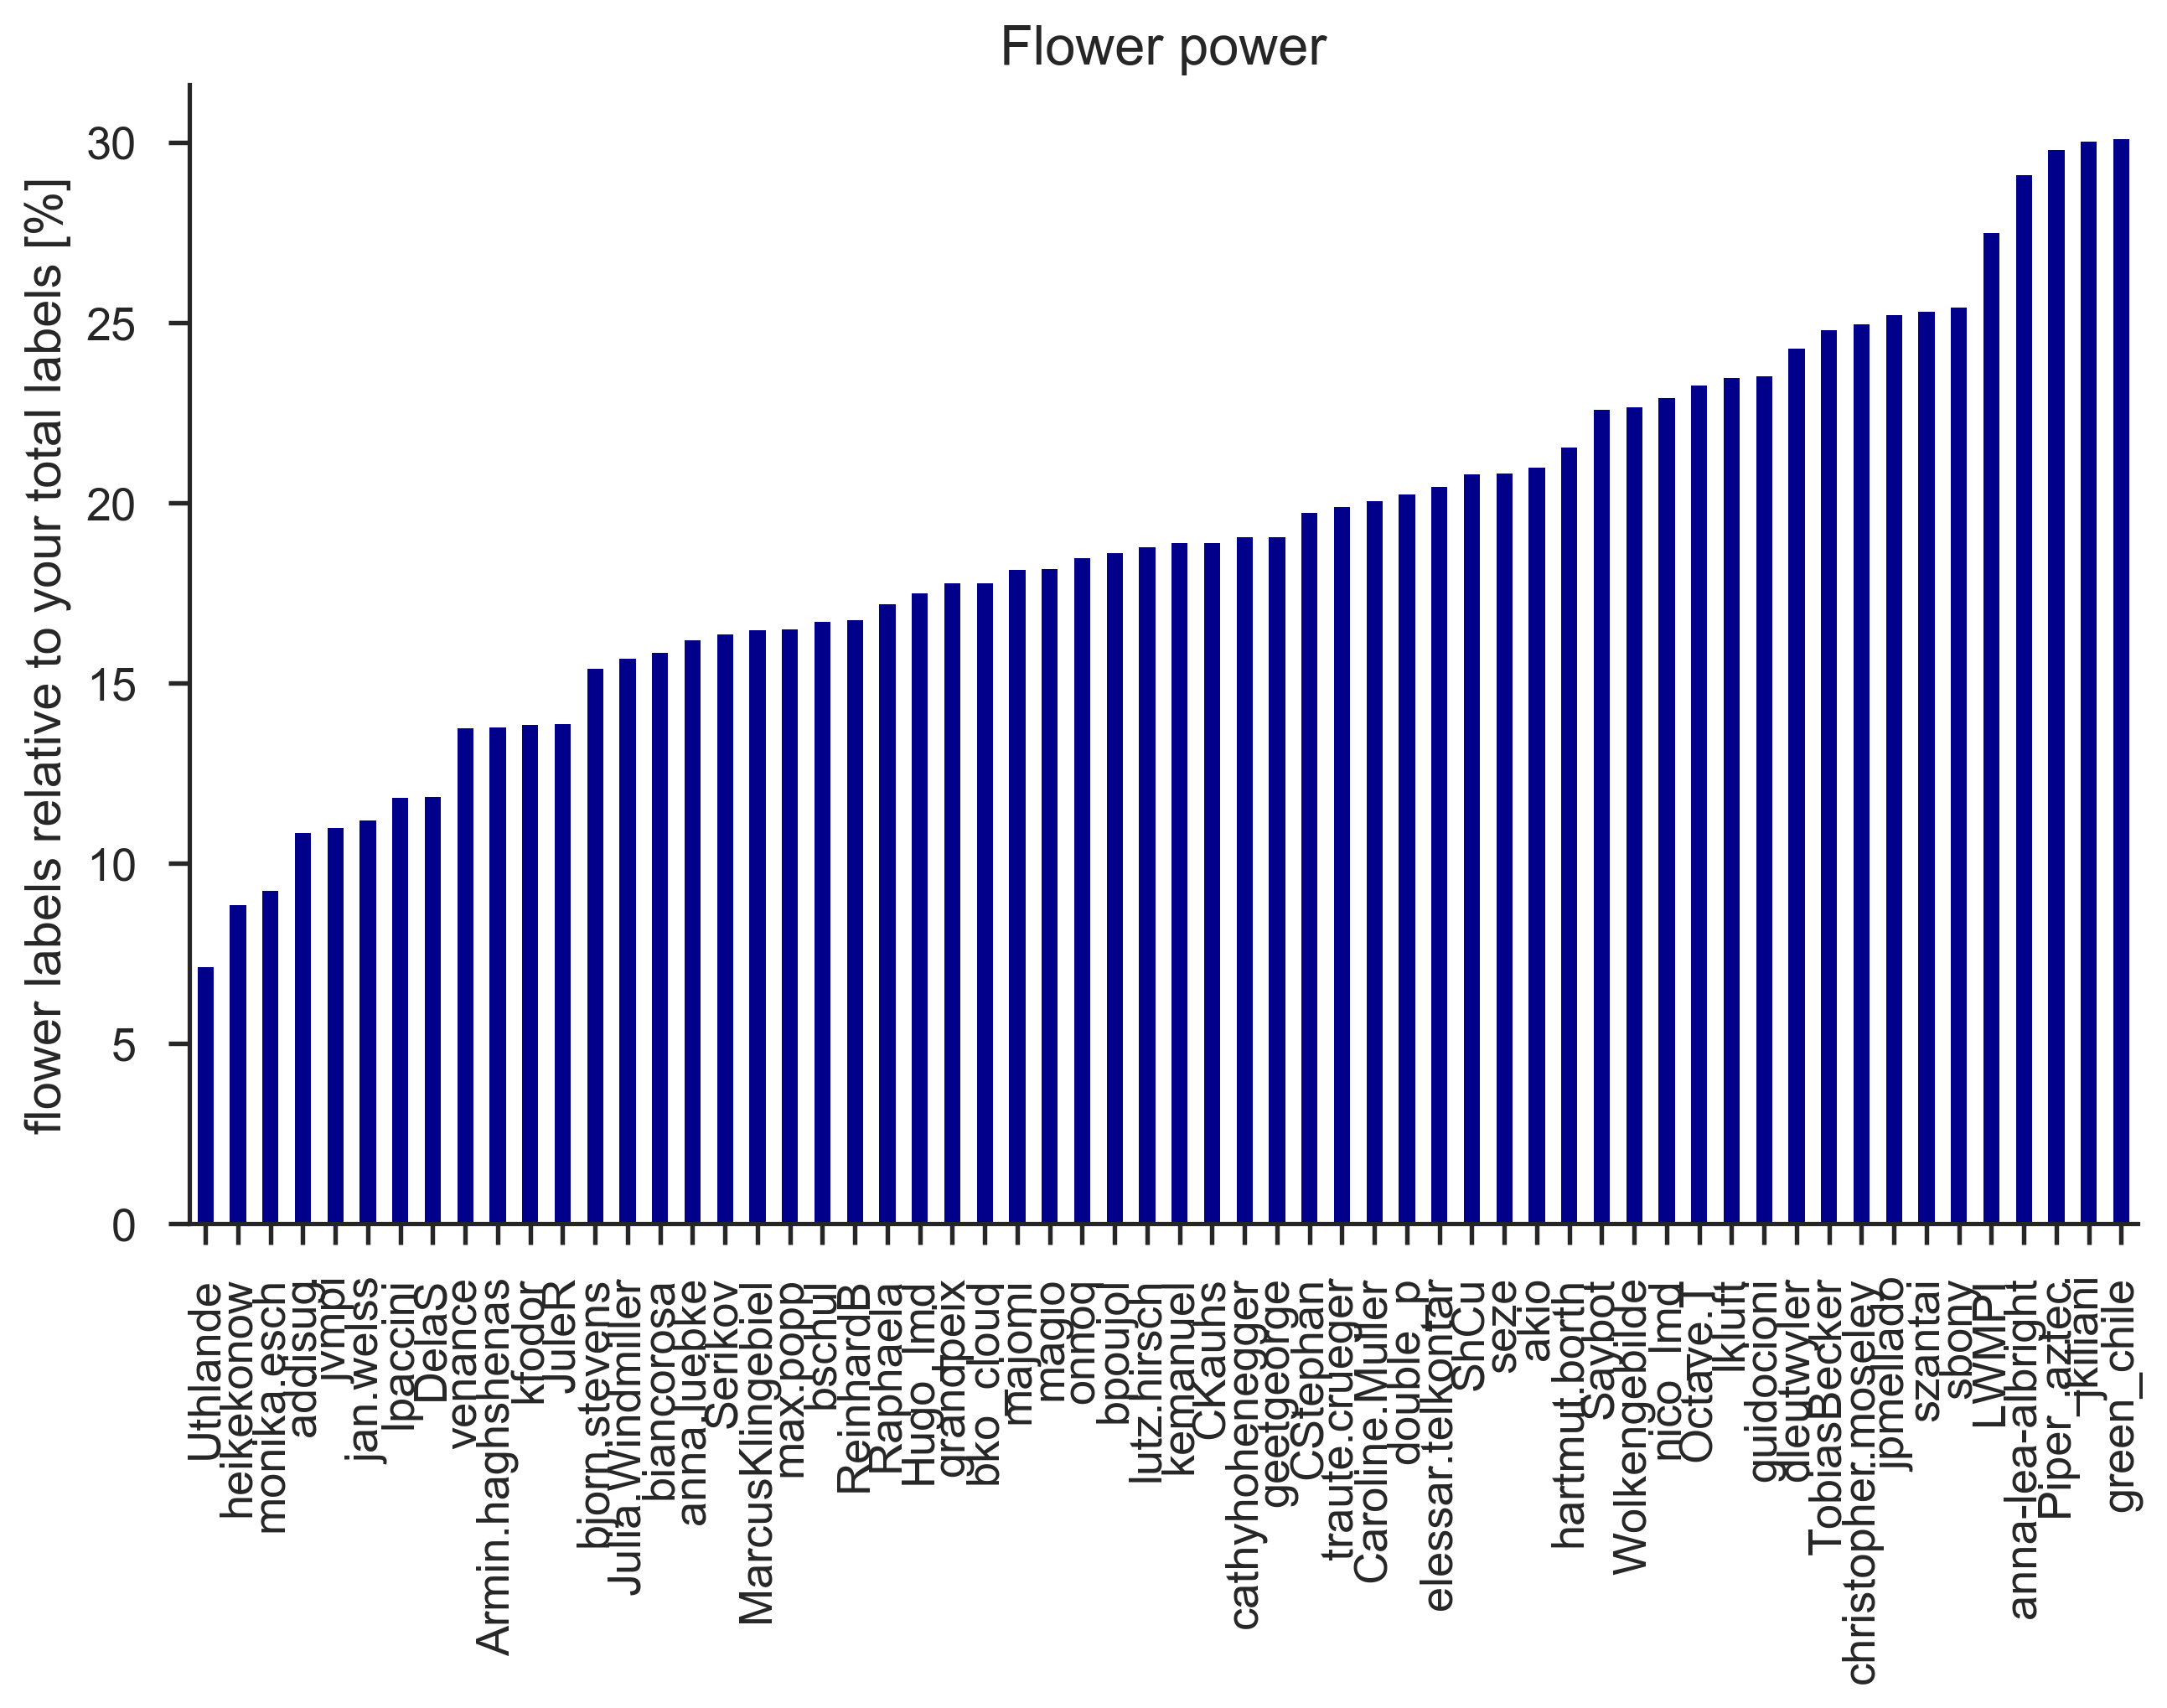

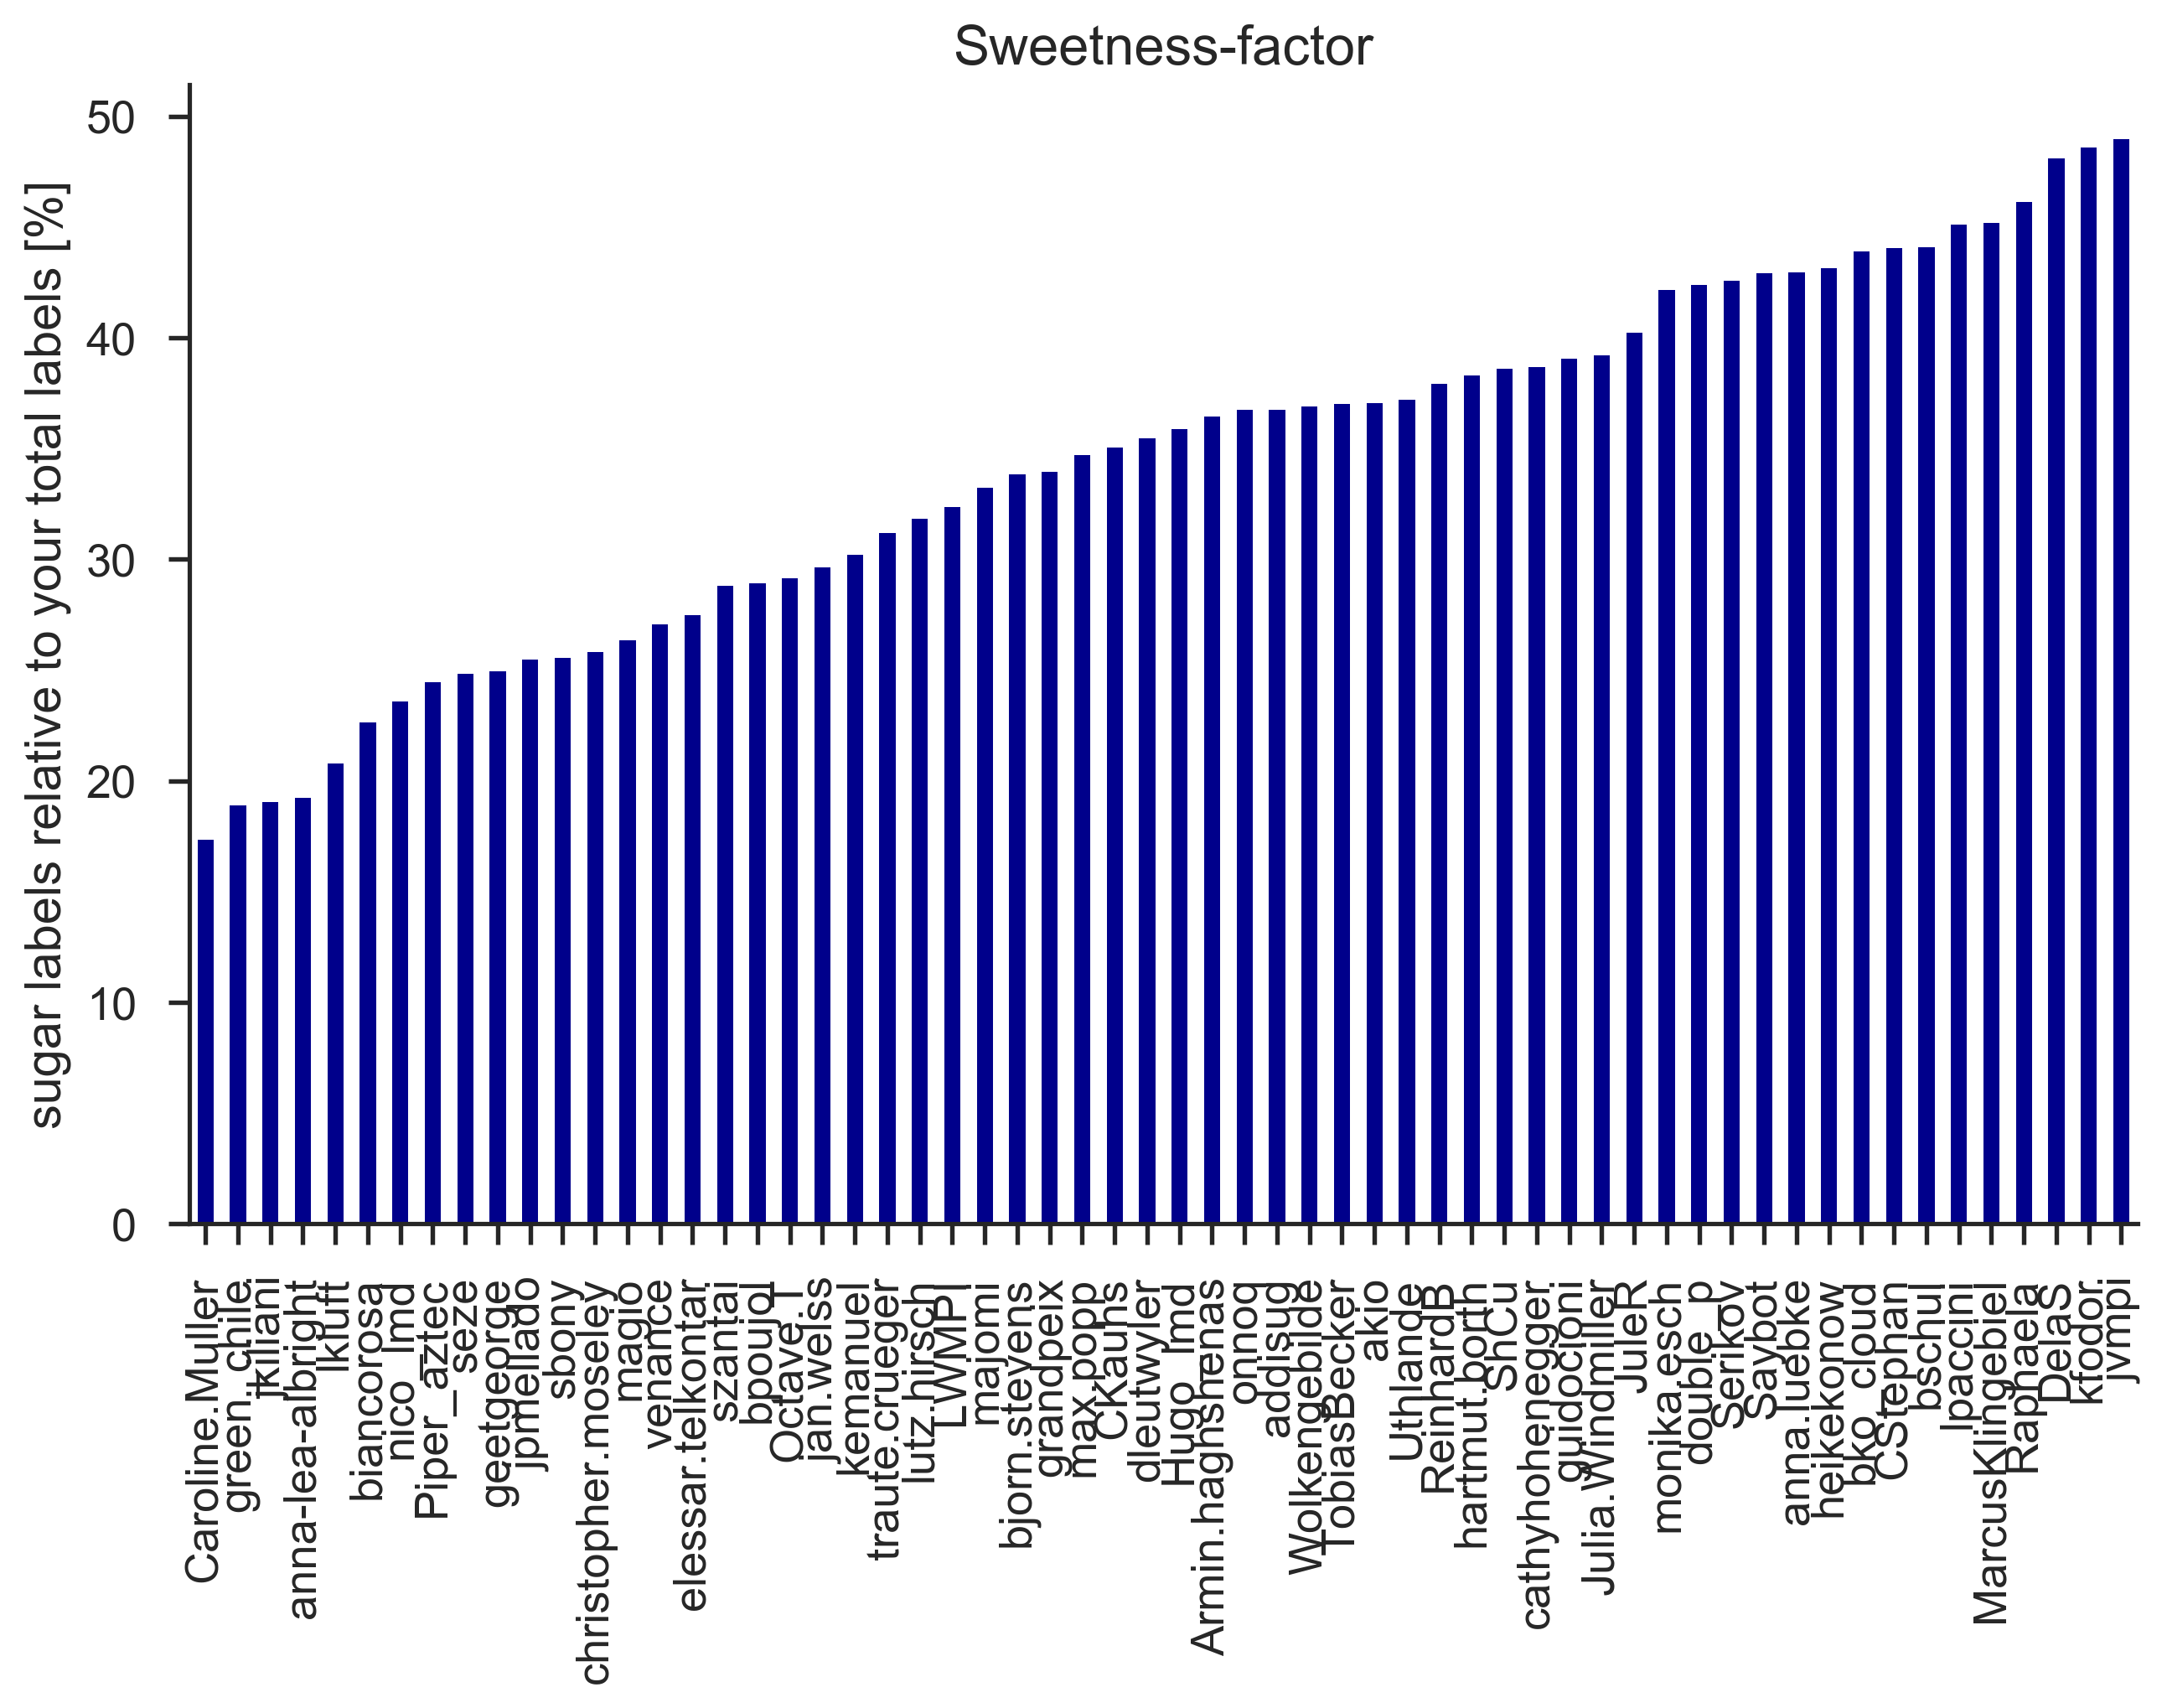

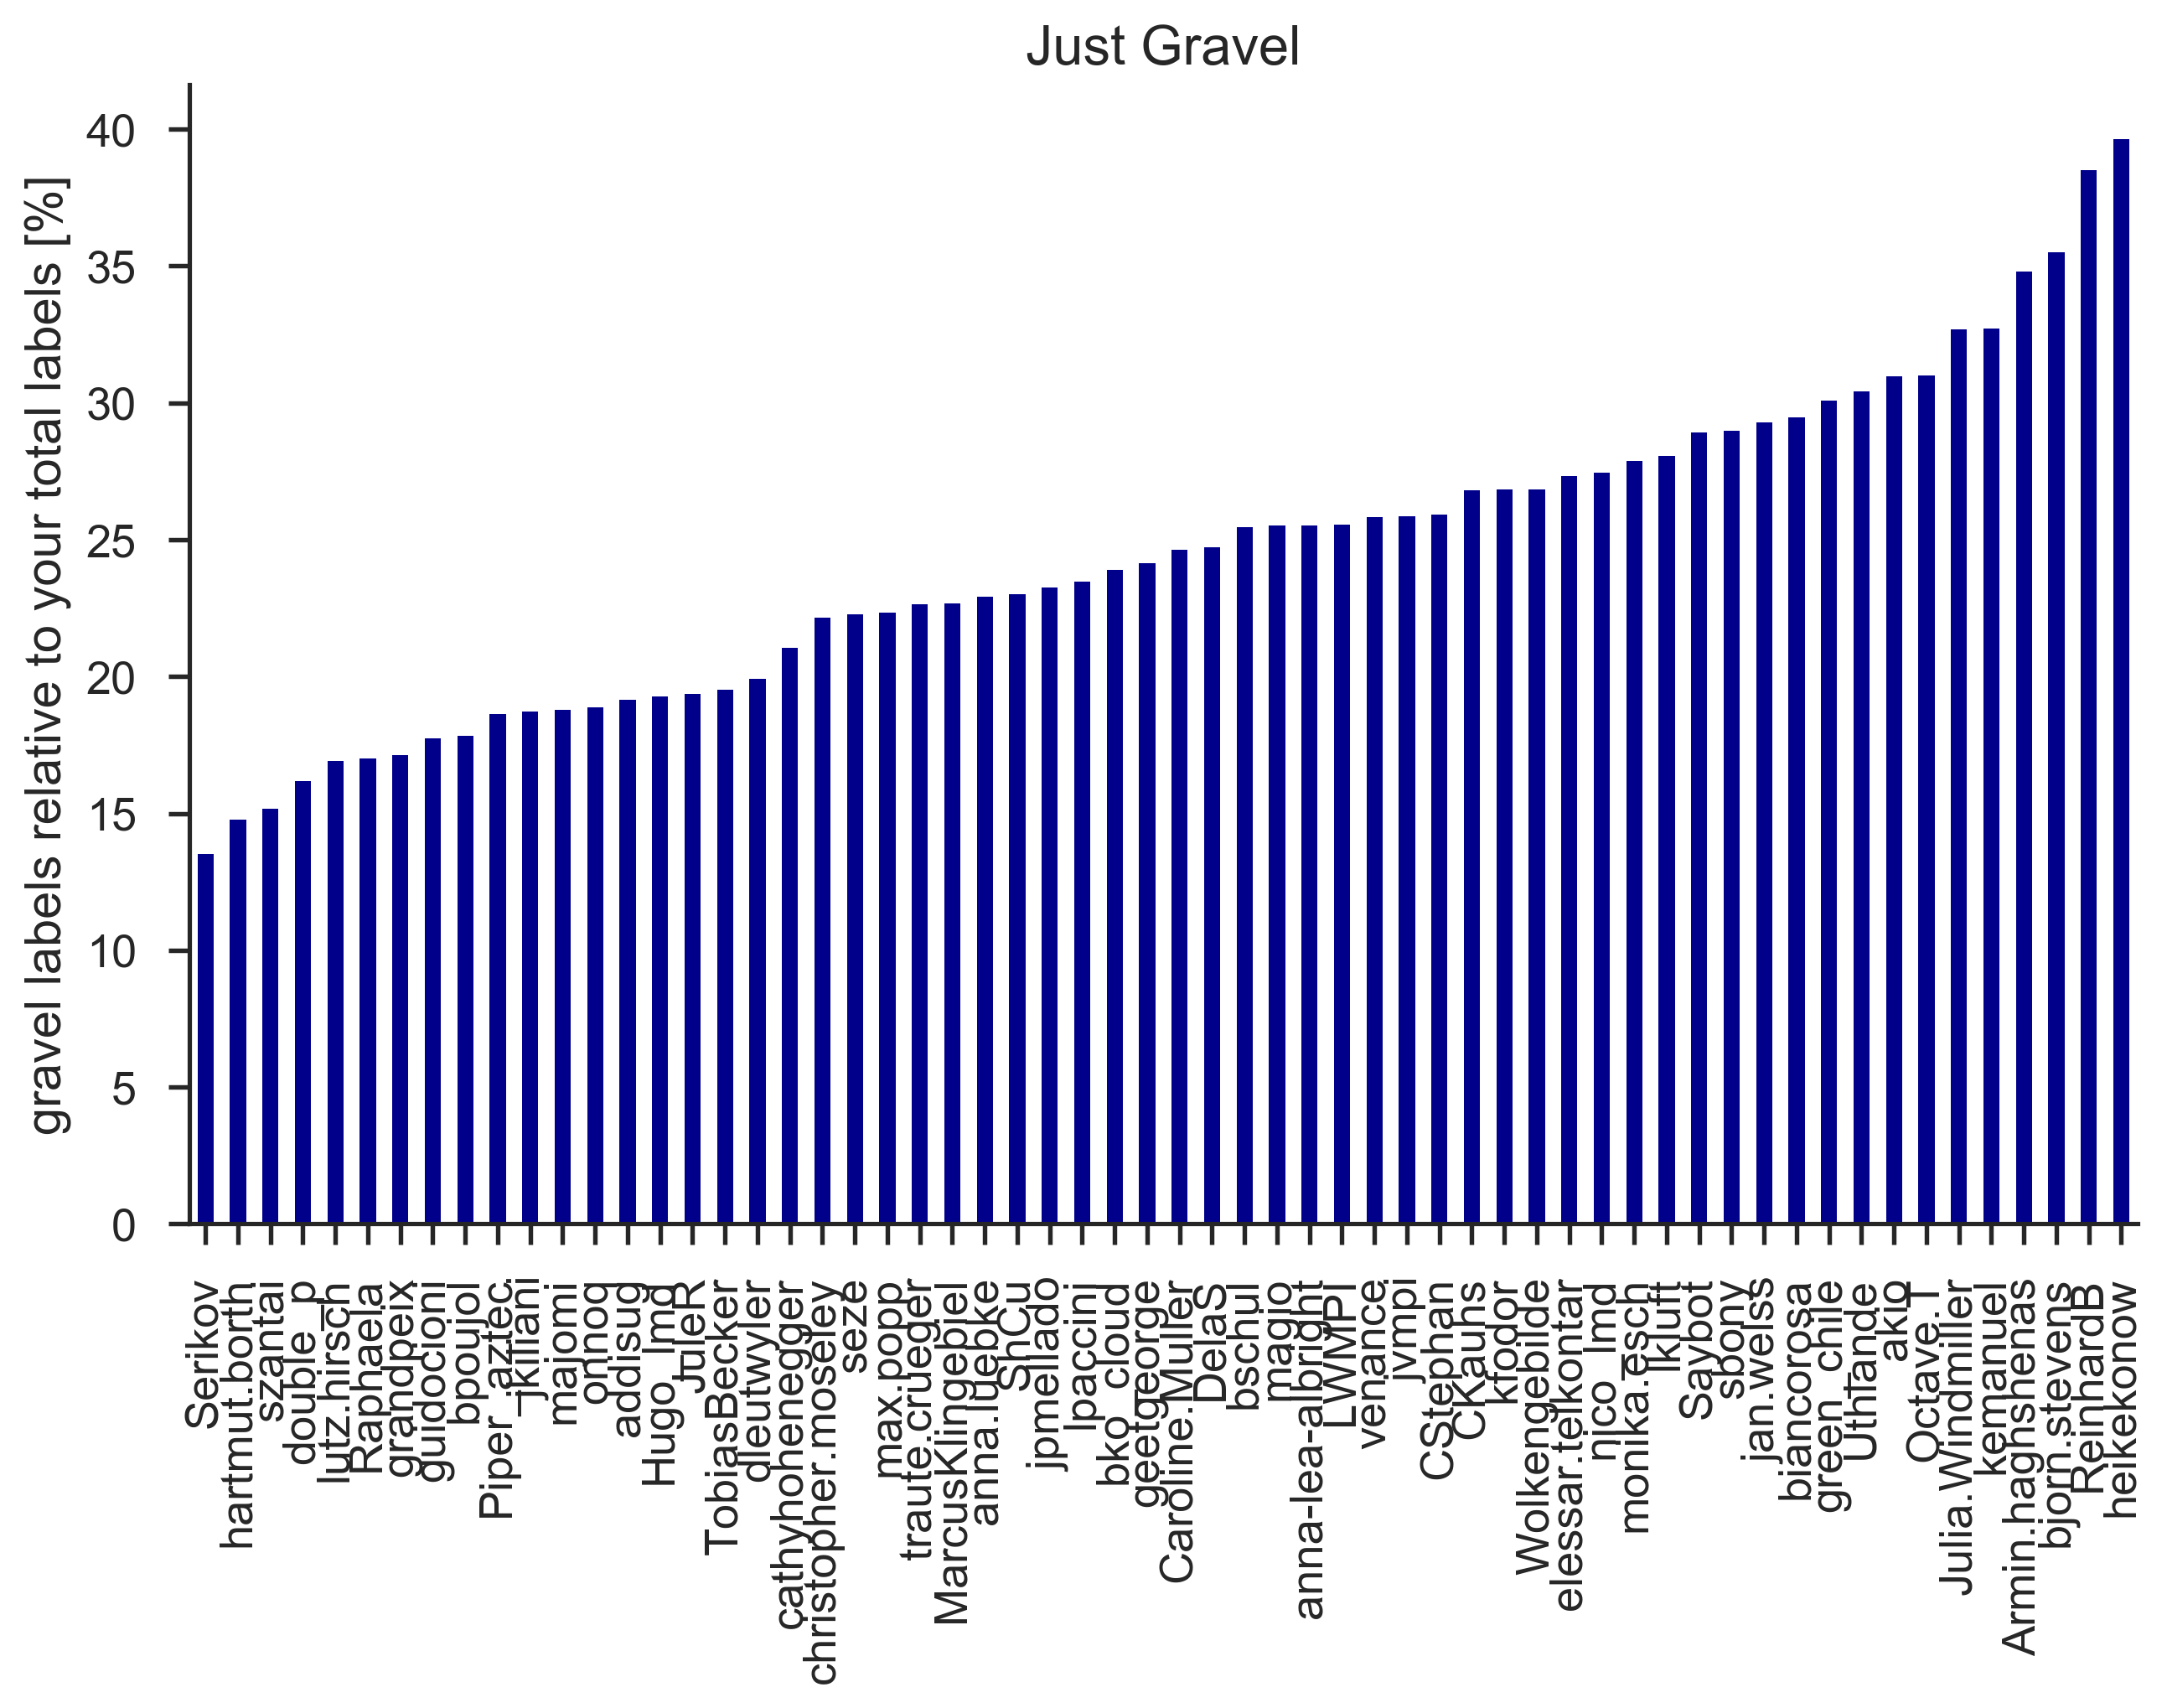

In [16]:
sns.set_context('talk')
sns.set_style('ticks')
titles=['Do you like fish?', 'Flower power', 'Sweetness-factor', 'Just Gravel']
for p,pattern in enumerate(['fish','flower','sugar','gravel']):
    plt.figure()
    pattern_percentage = pattern+'_percentage'
    DF_user[pattern_percentage] = DF_user[pattern]/DF_user.labels_done*100
    p1=DF_user.sort_values(pattern_percentage)[pattern_percentage].plot(kind='bar', figsize=(10,6), color='darkblue')
    t=p1.set_ylabel('{} labels relative to your total labels [%]'.format(pattern))
    #p1.set_title('Do you like {}?'.format(pattern))
    p1.set_title(titles[p])
    plt.gcf().set_dpi(300)
    sns.despine()

# Time spent

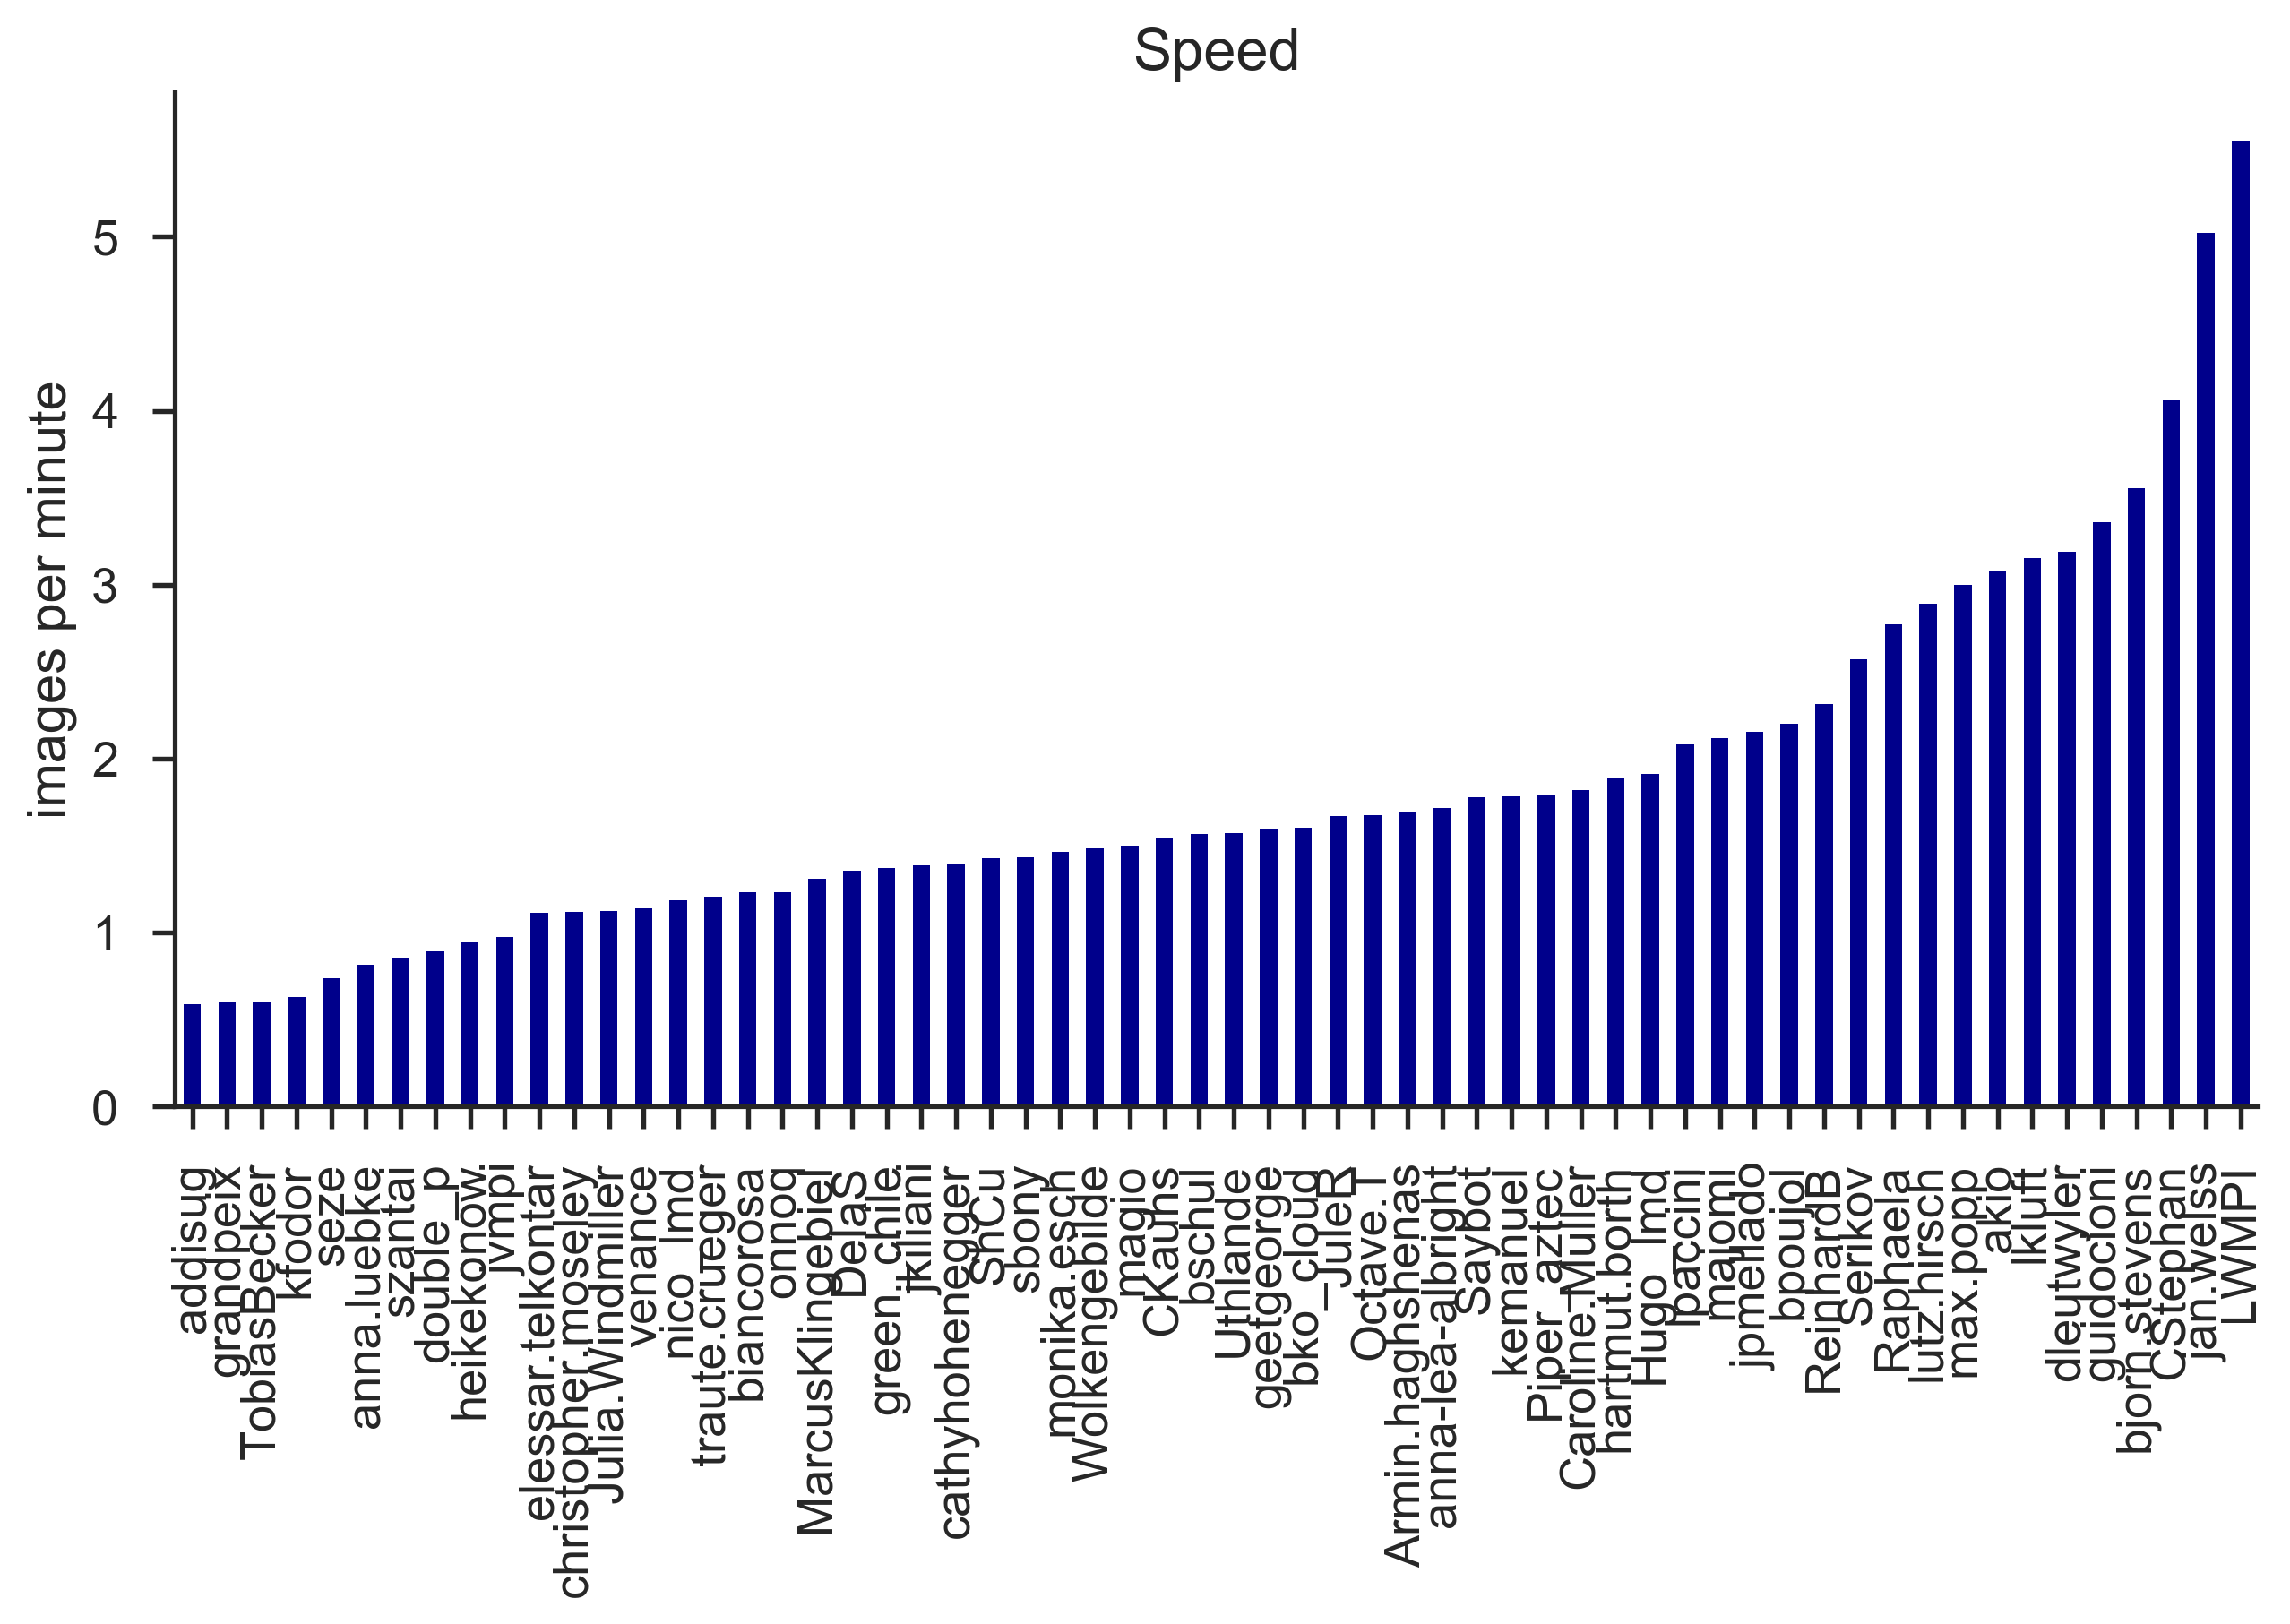

In [17]:
sns.set_context('talk')
sns.set_style('ticks')
DF_user['images_per_minute'] = 60/(DF_user.time_spent/DF_user.images_seen)
p1=DF_user.sort_values('images_per_minute').images_per_minute.plot(kind='bar', figsize=(10,5), stacked=True, color='darkblue')
#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
t=p1.set_ylabel('images per minute')
p1.set_title('Speed')
plt.gcf().set_dpi(300)
sns.despine()

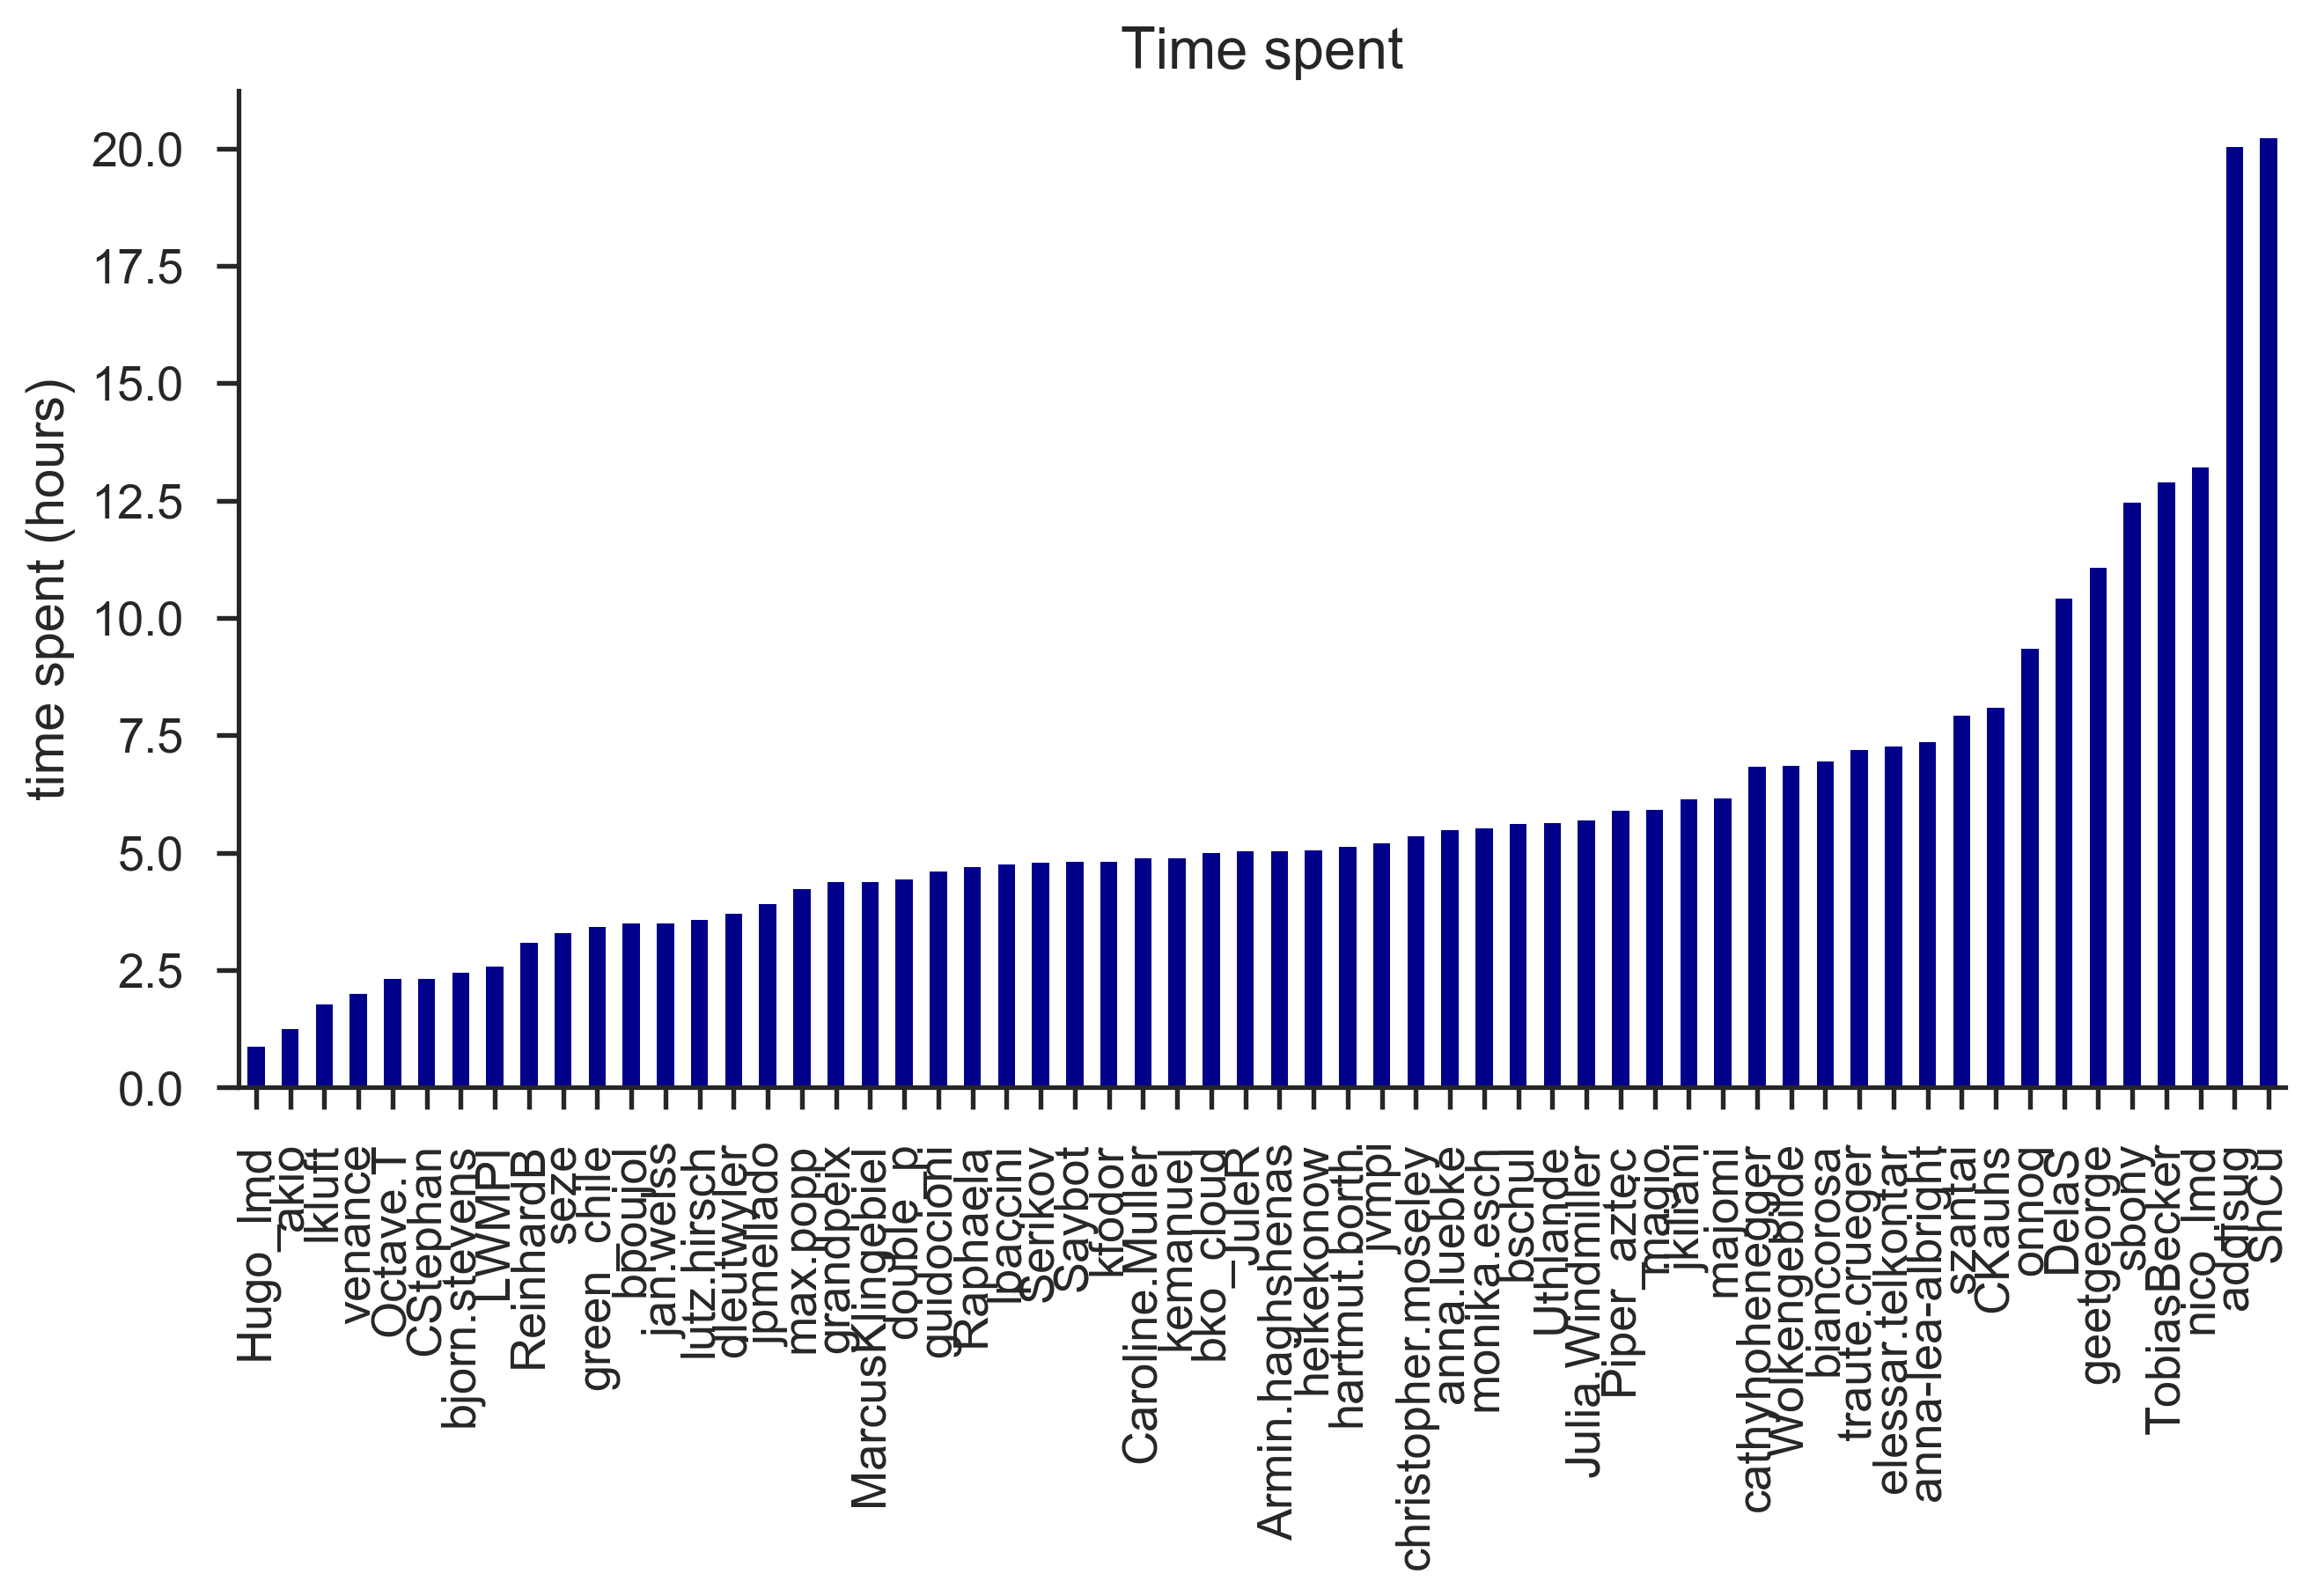

In [18]:
sns.set_context('talk')
sns.set_style('ticks')
p1=(DF_user.sort_values('time_spent').time_spent/3600).plot(kind='bar', figsize=(10,5), stacked=True, color='darkblue')
#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
t=p1.set_ylabel('time spent (hours)')
p1.set_title('Time spent')
plt.gcf().set_dpi(300)
sns.despine()

# Subject set statistics

In [19]:
subject_data = load_classifications(subject_in)
subject_data = subject_data.set_index('subject_id'); subject_data.head()

project_id  workflow_id  subject_set_id  \
subject_id                                            
26976345          7699          NaN           60713   
26976346          7699          NaN           60713   
26976347          7699          NaN           60713   
26976348          7699          NaN           60713   
26976349          7699          NaN           60713   

                                                     metadata  \
subject_id                                                      
26976345    {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
26976346    {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
26976347    {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
26976348    {'fn': '/project/meteo/work/S.Rasp/cloud-class...   
26976349    {'fn': '/project/meteo/work/S.Rasp/cloud-class...   

                                                    locations  \
subject_id                                                      
26976345    {"0":"https://panoptes-uploads.zooniverse.org/...   
26976346    {"0":"https://panoptes-uploads.zooniverse.org/...   
26976347    {"0":"https://panoptes-uploads.zooniverse.org/...   
26976348    {"0":"https://panoptes-uploads.zooniverse.org/...   
26976349    {"0":"https://panoptes-uploads.zooniverse.org/...   

            classifications_count retired_at retirement_reason  \
subject_id                                                       
26976345                        0        NaN               NaN   
26976346                        0        NaN               NaN   
26976347                        0        NaN               NaN   
26976348                        0        NaN               NaN   
26976349                        0        NaN               NaN   

                         created_at               updated_at  
subject_id                                                    
26976345    2018-10-24 16:42:28 UTC  2018-10-24 16:42:28 UTC  
26976346    2018-10-24 16:42:29 UTC  2018-10-24 16:42:29 UTC  
26976347    2018-10-24 16:42:31 UTC  2018-10-24 16:42:31 UTC  
26976348    2018-10-24 16:42:32 UTC  2018-10-24 16:42:32 UTC  
26976349    2018-10-24 16:42:33 UTC  2018-10-24 16:42:33 UTC

In [20]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}
for s, subject_set in subject_data.groupby('subject_set_id'):
    try:
        print(subjects_name[s])
        print(len(subject_set),subject_set.classifications_count.sum(),\
              len(subject_set.classifications_count.nonzero()[0]),\
              np.round(len(subject_set.classifications_count.nonzero()[0])/len(subject_set)*100,1))
        print('maximum number of classifications per image: {}'.format(subject_set.classifications_count.max()))
    except KeyError:
        print('Subset {} not of interest'.format(s))

Subset 60713 not of interest
Subset 60720 not of interest
Subset 60721 not of interest
Subset 60722 not of interest
BCO_DJF_Aqua
993 1867 854 86.0
maximum number of classifications per image: 5
BCO_DJF_Terra
993 1898 856 86.2
maximum number of classifications per image: 5
BCO_MAM_Aqua
1012 1874 853 84.3
maximum number of classifications per image: 5
BCO_MAM_Terra
1012 1922 881 87.1
maximum number of classifications per image: 5
R2_DJF_Aqua
993 1867 858 86.4
maximum number of classifications per image: 5
R2_DJF_Terra
993 1970 871 87.7
maximum number of classifications per image: 5
R3_DJF_Aqua
993 1897 869 87.5
maximum number of classifications per image: 5
R3_DJF_Terra
993 1956 881 88.7
maximum number of classifications per image: 5
R3_SON_Aqua
1001 1891 869 86.8
maximum number of classifications per image: 4
Subset 60834 not of interest
R3_SON_Terra
1001 1929 881 88.0
maximum number of classifications per image: 5
Subset 60836 not of interest
Subset 60902 not of interest


# Distribution of pattern within region

In [21]:
def update_dict(region_dic,region_id, dic):
    # user existiert bereits
    if region_dic.get(region_id) != None:
        for key in dic.keys():
            if region_dic[region_id].get(key) != None:
                old_value = region_dic[region_id][key]
                new_value = old_value+dic[key]
                region_dic[region_id][key]=new_value
            else:
                region_dic[region_id][key]=dic[key]
    else:
        region_dic[region_id] = dic
    return region_dic

In [22]:
region_stat = {}
for e,entry in enumerate(classification_data.iterrows()):
    nb_fish = nb_gravel = nb_flower = nb_sugar = 0
    subject_id = entry[1].subject_ids
    workflow_c_id = entry[1].workflow_id
    pattern_types = entry[1].annotations
    labels = [value['tool'] for value in pattern_types['value']]
    [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels,minlength=4)
    try:
        ind = np.where(subject_id == subject_data.index.values)[0][0]
        subset_id = subject_data.subject_set_id.values[ind]
        workflow_id = subject_data.workflow_id.values[ind]
        if workflow_c_id == np.float(8073):
            try:
                region_name = subjects_name[subset_id]
                region_stat = update_dict(region_stat, region_name, {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar})
            except KeyError:
                continue
    except:
        continue

In [23]:
region_stat

{'R2_DJF_Aqua': {'fish': 1427, 'gravel': 1407, 'flower': 304, 'sugar': 2099},
 'R3_DJF_Aqua': {'fish': 712, 'gravel': 717, 'flower': 882, 'sugar': 1669},
 'R3_SON_Aqua': {'fish': 900, 'gravel': 599, 'flower': 1154, 'sugar': 1630},
 'BCO_DJF_Aqua': {'fish': 1091, 'gravel': 1898, 'flower': 455, 'sugar': 1445},
 'R2_DJF_Terra': {'fish': 1362, 'gravel': 1228, 'flower': 509, 'sugar': 1769},
 'BCO_MAM_Aqua': {'fish': 834, 'gravel': 1107, 'flower': 545, 'sugar': 1170},
 'R3_SON_Terra': {'fish': 804, 'gravel': 460, 'flower': 1738, 'sugar': 1359},
 'BCO_MAM_Terra': {'fish': 892, 'gravel': 834, 'flower': 902, 'sugar': 1062},
 'R3_DJF_Terra': {'fish': 633, 'gravel': 527, 'flower': 1297, 'sugar': 1530},
 'BCO_DJF_Terra': {'fish': 1127, 'gravel': 1671, 'flower': 607, 'sugar': 1220}}

In [24]:
total = np.asarray(pd.DataFrame.from_dict(region_stat)).sum(axis=1)

In [25]:
x=pd.DataFrame.from_dict(region_stat,orient='index')
x['region'] = [0,0,1,1,2,2,3,3,4,4]

In [26]:
x

fish  gravel  flower  sugar  region
BCO_DJF_Aqua   1091    1898     455   1445       0
BCO_DJF_Terra  1127    1671     607   1220       0
BCO_MAM_Aqua    834    1107     545   1170       1
BCO_MAM_Terra   892     834     902   1062       1
R2_DJF_Aqua    1427    1407     304   2099       2
R2_DJF_Terra   1362    1228     509   1769       2
R3_DJF_Aqua     712     717     882   1669       3
R3_DJF_Terra    633     527    1297   1530       3
R3_SON_Aqua     900     599    1154   1630       4
R3_SON_Terra    804     460    1738   1359       4

In [27]:
region_result = {}
for region, region_grp in x.groupby('region'):
    region_result[region_grp.index.values[0][:-5]] = region_grp.sum()

In [28]:
region_stat2 = region_result

In [29]:
sum(total)

43576

In [30]:
total_column_names = ['fish', 'flower','gravel','sugar']

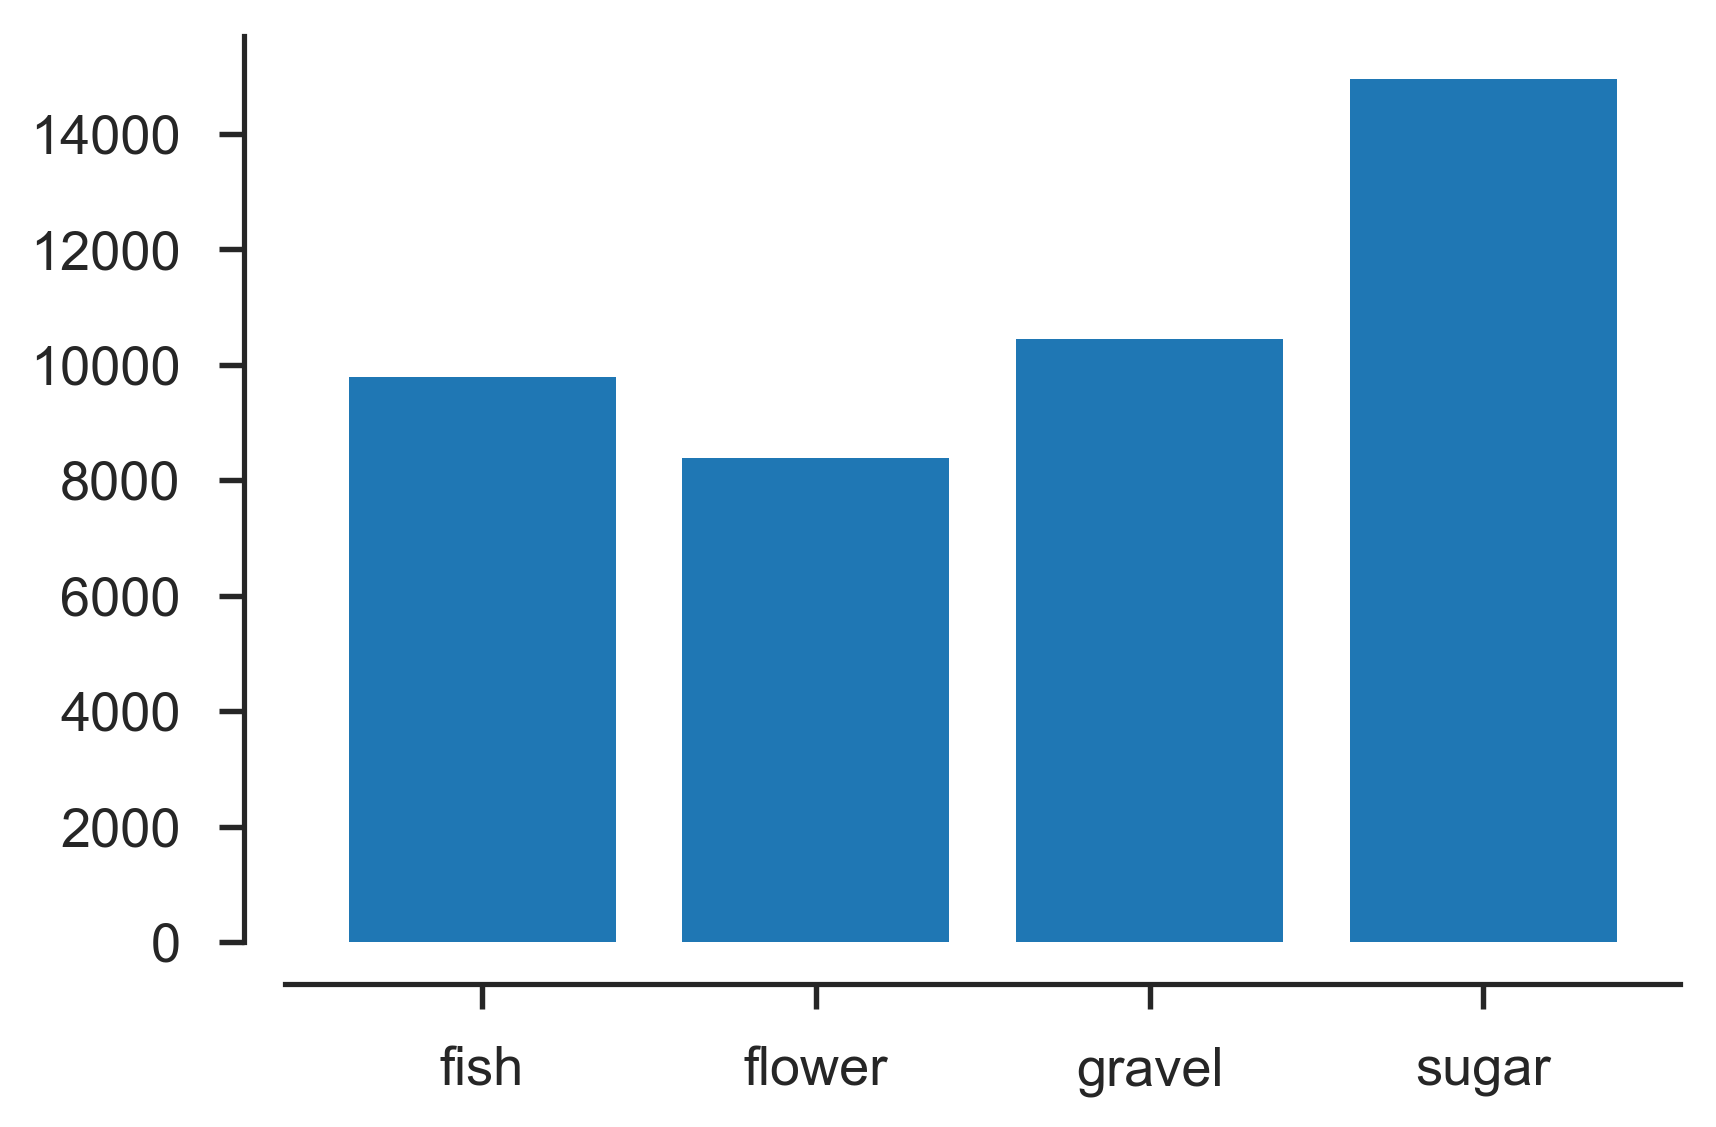

In [31]:
plt.bar(total_column_names,total)
sns.despine(offset=10)
plt.gcf().set_dpi(300)

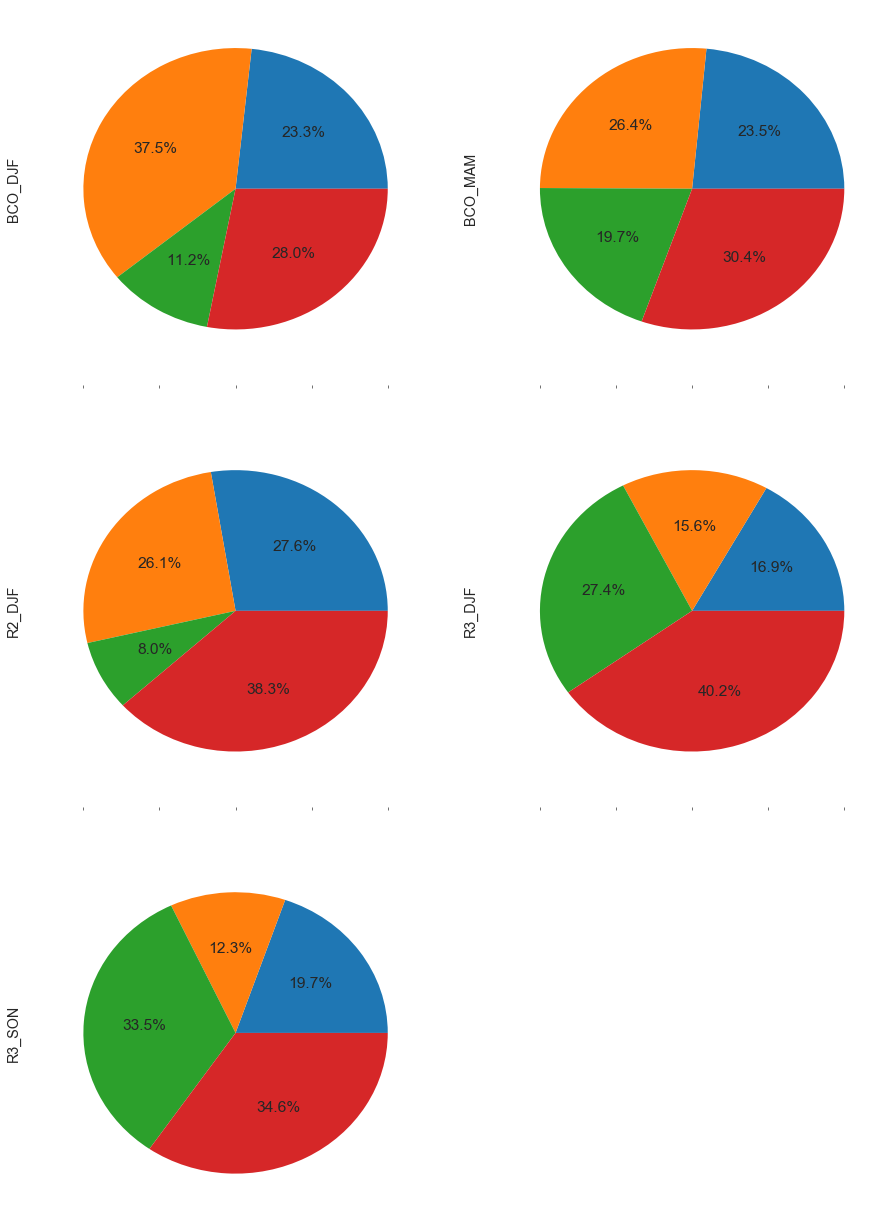

In [32]:
DF=pd.DataFrame.from_dict(region_stat2,orient='columns')
DF.drop('region',inplace=True)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

DF.plot(kind='pie',figsize=(15,22),subplots=True,layout=(3, 2),labels=None,legend=None,autopct='%1.1f%%',yticks=None)
ax=plt.gca()
sns.despine(offset=20)

In [33]:
# or just another layout of the same data

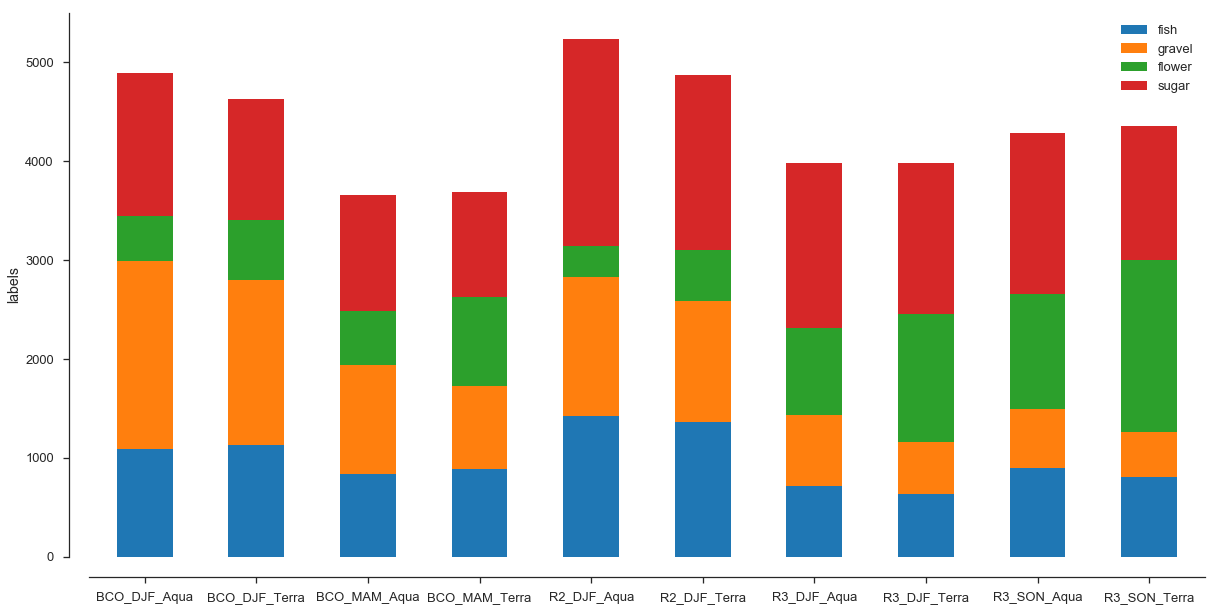

In [34]:
DF=pd.DataFrame.from_dict(region_stat,orient='index')

p=DF.plot(kind='bar',figsize=(20,10),stacked=True)
p.set_ylabel('labels')
sns.despine(offset=20)

The above figure includes both, the practice workflow and the full dataset workflow.

It looks like there is a difference between Aqua and Terra overpasses. Flowers are always less during Aqua than during Terra!

In [36]:
DF['total'] = DF.iloc[:,[0,1,2,3]].sum(axis=1); DF

fish  gravel  flower  sugar  total
BCO_DJF_Aqua   1091    1898     455   1445   4889
BCO_DJF_Terra  1127    1671     607   1220   4625
BCO_MAM_Aqua    834    1107     545   1170   3656
BCO_MAM_Terra   892     834     902   1062   3690
R2_DJF_Aqua    1427    1407     304   2099   5237
R2_DJF_Terra   1362    1228     509   1769   4868
R3_DJF_Aqua     712     717     882   1669   3980
R3_DJF_Terra    633     527    1297   1530   3987
R3_SON_Aqua     900     599    1154   1630   4283
R3_SON_Terra    804     460    1738   1359   4361

### Calculating the relative differences between the Aqua and Terra data

In [37]:
DF.loc['BCO_DJF_diff'] = DF.iloc[0,[0,1,2,3]]/DF.iloc[0,4]*100-DF.iloc[1,[0,1,2,3]]/DF.iloc[1,4]*100
DF.loc['BCO_MAM_diff'] = DF.iloc[2,[0,1,2,3]]/DF.iloc[2,4]*100-DF.iloc[3,[0,1,2,3]]/DF.iloc[3,4]*100
DF.loc['R2_DJF_diff'] = DF.iloc[4,[0,1,2,3]]/DF.iloc[4,4]*100-DF.iloc[5,[0,1,2,3]]/DF.iloc[5,4]*100
DF.loc['R3_DJF_diff'] = DF.iloc[6,[0,1,2,3]]/DF.iloc[6,4]*100-DF.iloc[7,[0,1,2,3]]/DF.iloc[7,4]*100
DF.loc['R3_SON_diff'] = DF.iloc[8,[0,1,2,3]]/DF.iloc[8,4]*100-DF.iloc[9,[0,1,2,3]]/DF.iloc[9,4]*100

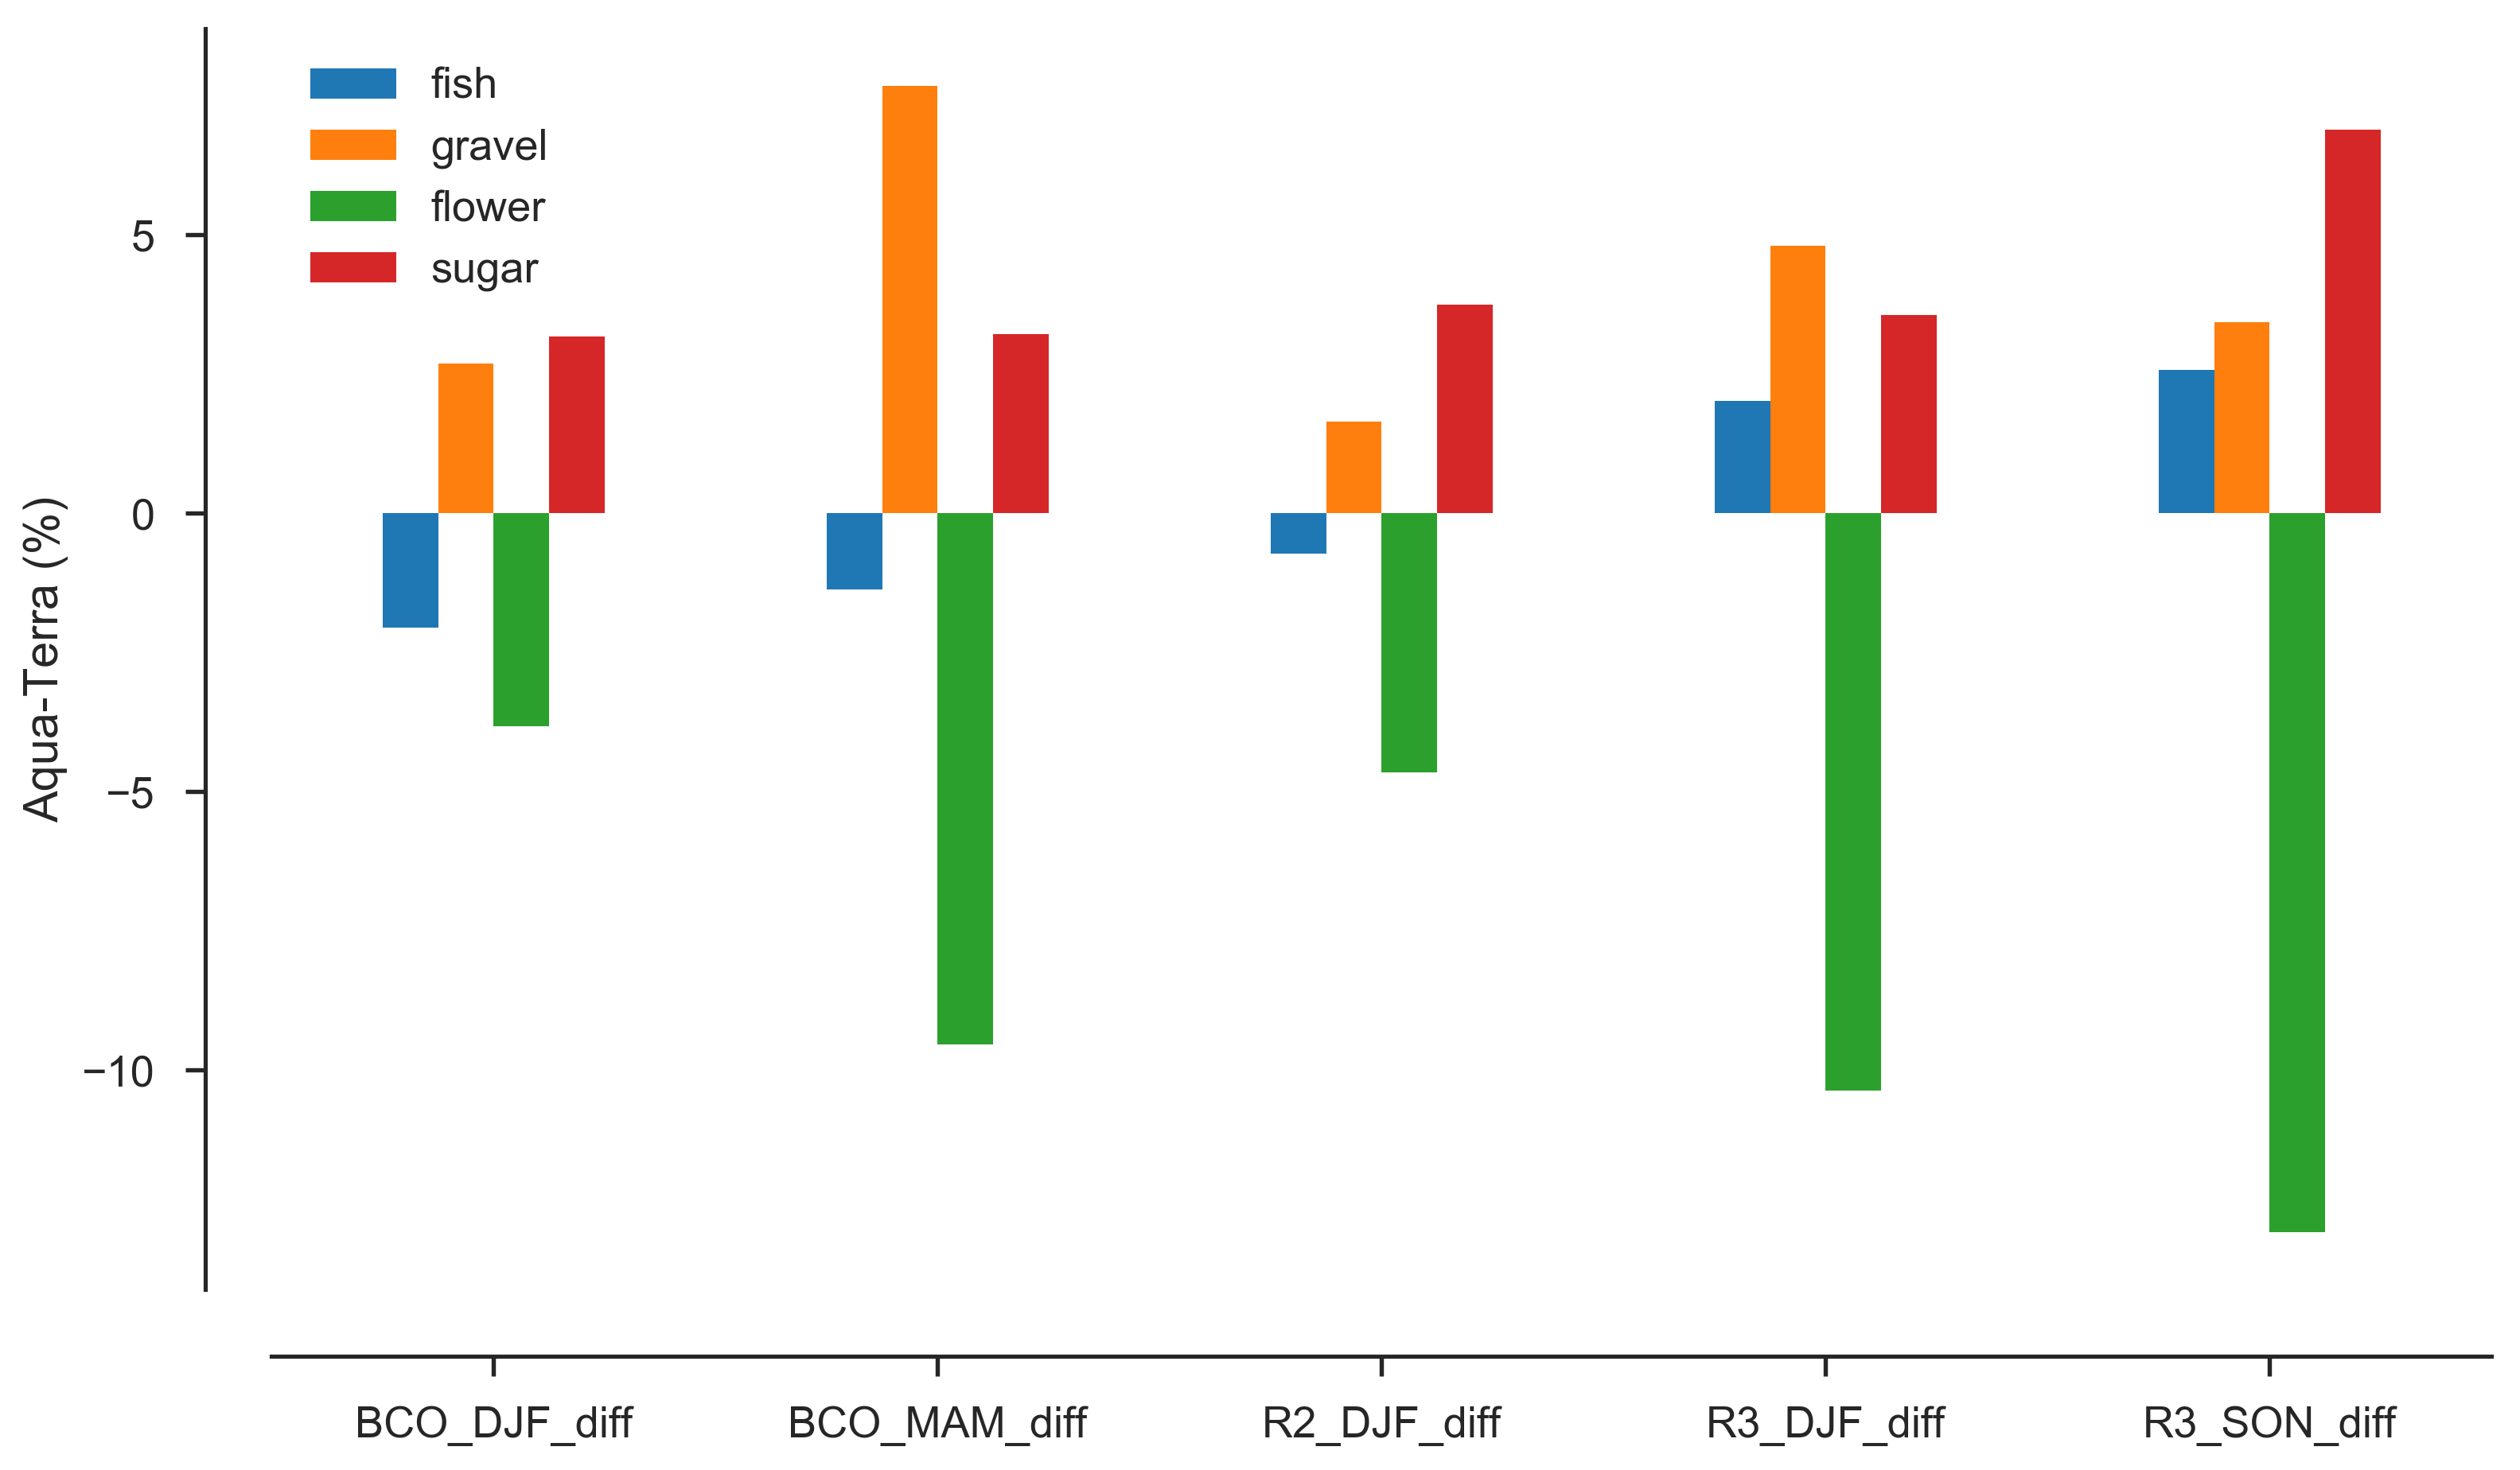

In [38]:
p=DF.loc[['BCO_DJF_diff','BCO_MAM_diff','R2_DJF_diff','R3_DJF_diff','R3_SON_diff'],['fish','gravel','flower','sugar']].plot(kind='bar',figsize=(12,7),stacked=False)
p.set_ylabel('Aqua-Terra (%)')
sns.despine(offset=20)
plt.gcf().set_dpi(300)

So the difference between the overpasses is quite obvious. However, the *flower* classifications are always less during Aqua overpasses, but for the region BCO in DJF, where there is no significant change at all.
( Check if that changes when the practice dataset is excluded )

# Practical dataset



In [39]:
image_stat = {}
for e,entry in enumerate(classification_data.iterrows()):
    if entry[1].workflow_id == np.float(8072): #Practical workflow
        nb_fish = nb_gravel = nb_flower = nb_sugar = 0
        subject_id = entry[1].subject_ids
        pattern_types = entry[1].annotations
        labels = [value['tool'] for value in pattern_types['value']]
        [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels,minlength=4)
        try:
            ind = np.where(subject_id == subject_data.index.values)[0][1] #<-- 0: BCO_DJF_Aqua, 1: practice 50 images
            subset_id = subject_data.subject_set_id.values[ind]
            if subset_id == np.float(60902): #check again for savety
                try:
                    image_name = subject_id
                    image_stat = update_dict(image_stat, image_name, {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar})
                except KeyError:
                    continue
                #image_stat[e] = {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar}
        except:
            continue

In [40]:
practical_image_DF = pd.DataFrame.from_dict(image_stat); practical_image_DF

27140534  27139862  27140428  27139658  27140338  27140007  27140443  \
fish          11        13        32         0        37        41        80   
flower         3        14        12         0         4        19        63   
gravel        29         4        56        38        41        17        38   
sugar         72        61         8        19         9        19         5   

        27140160  27140411  27139807    ...     27139823  27140434  27140513  \
fish           9        16        57    ...            3        15        30   
flower         0         0         0    ...            0        50         0   
gravel        52        54        47    ...           76         8        37   
sugar         42        13        19    ...           22        29        14   

        27140456  27139668  27140002  27139902  27140299  27140038  27140128  
fish           5         4         7        46        15        17        14  
flower        35         1         0         3         6        10         1  
gravel        46        36        32        43        19        36         9  
sugar          6        10        22        17        47        21         1  

[4 rows x 50 columns]

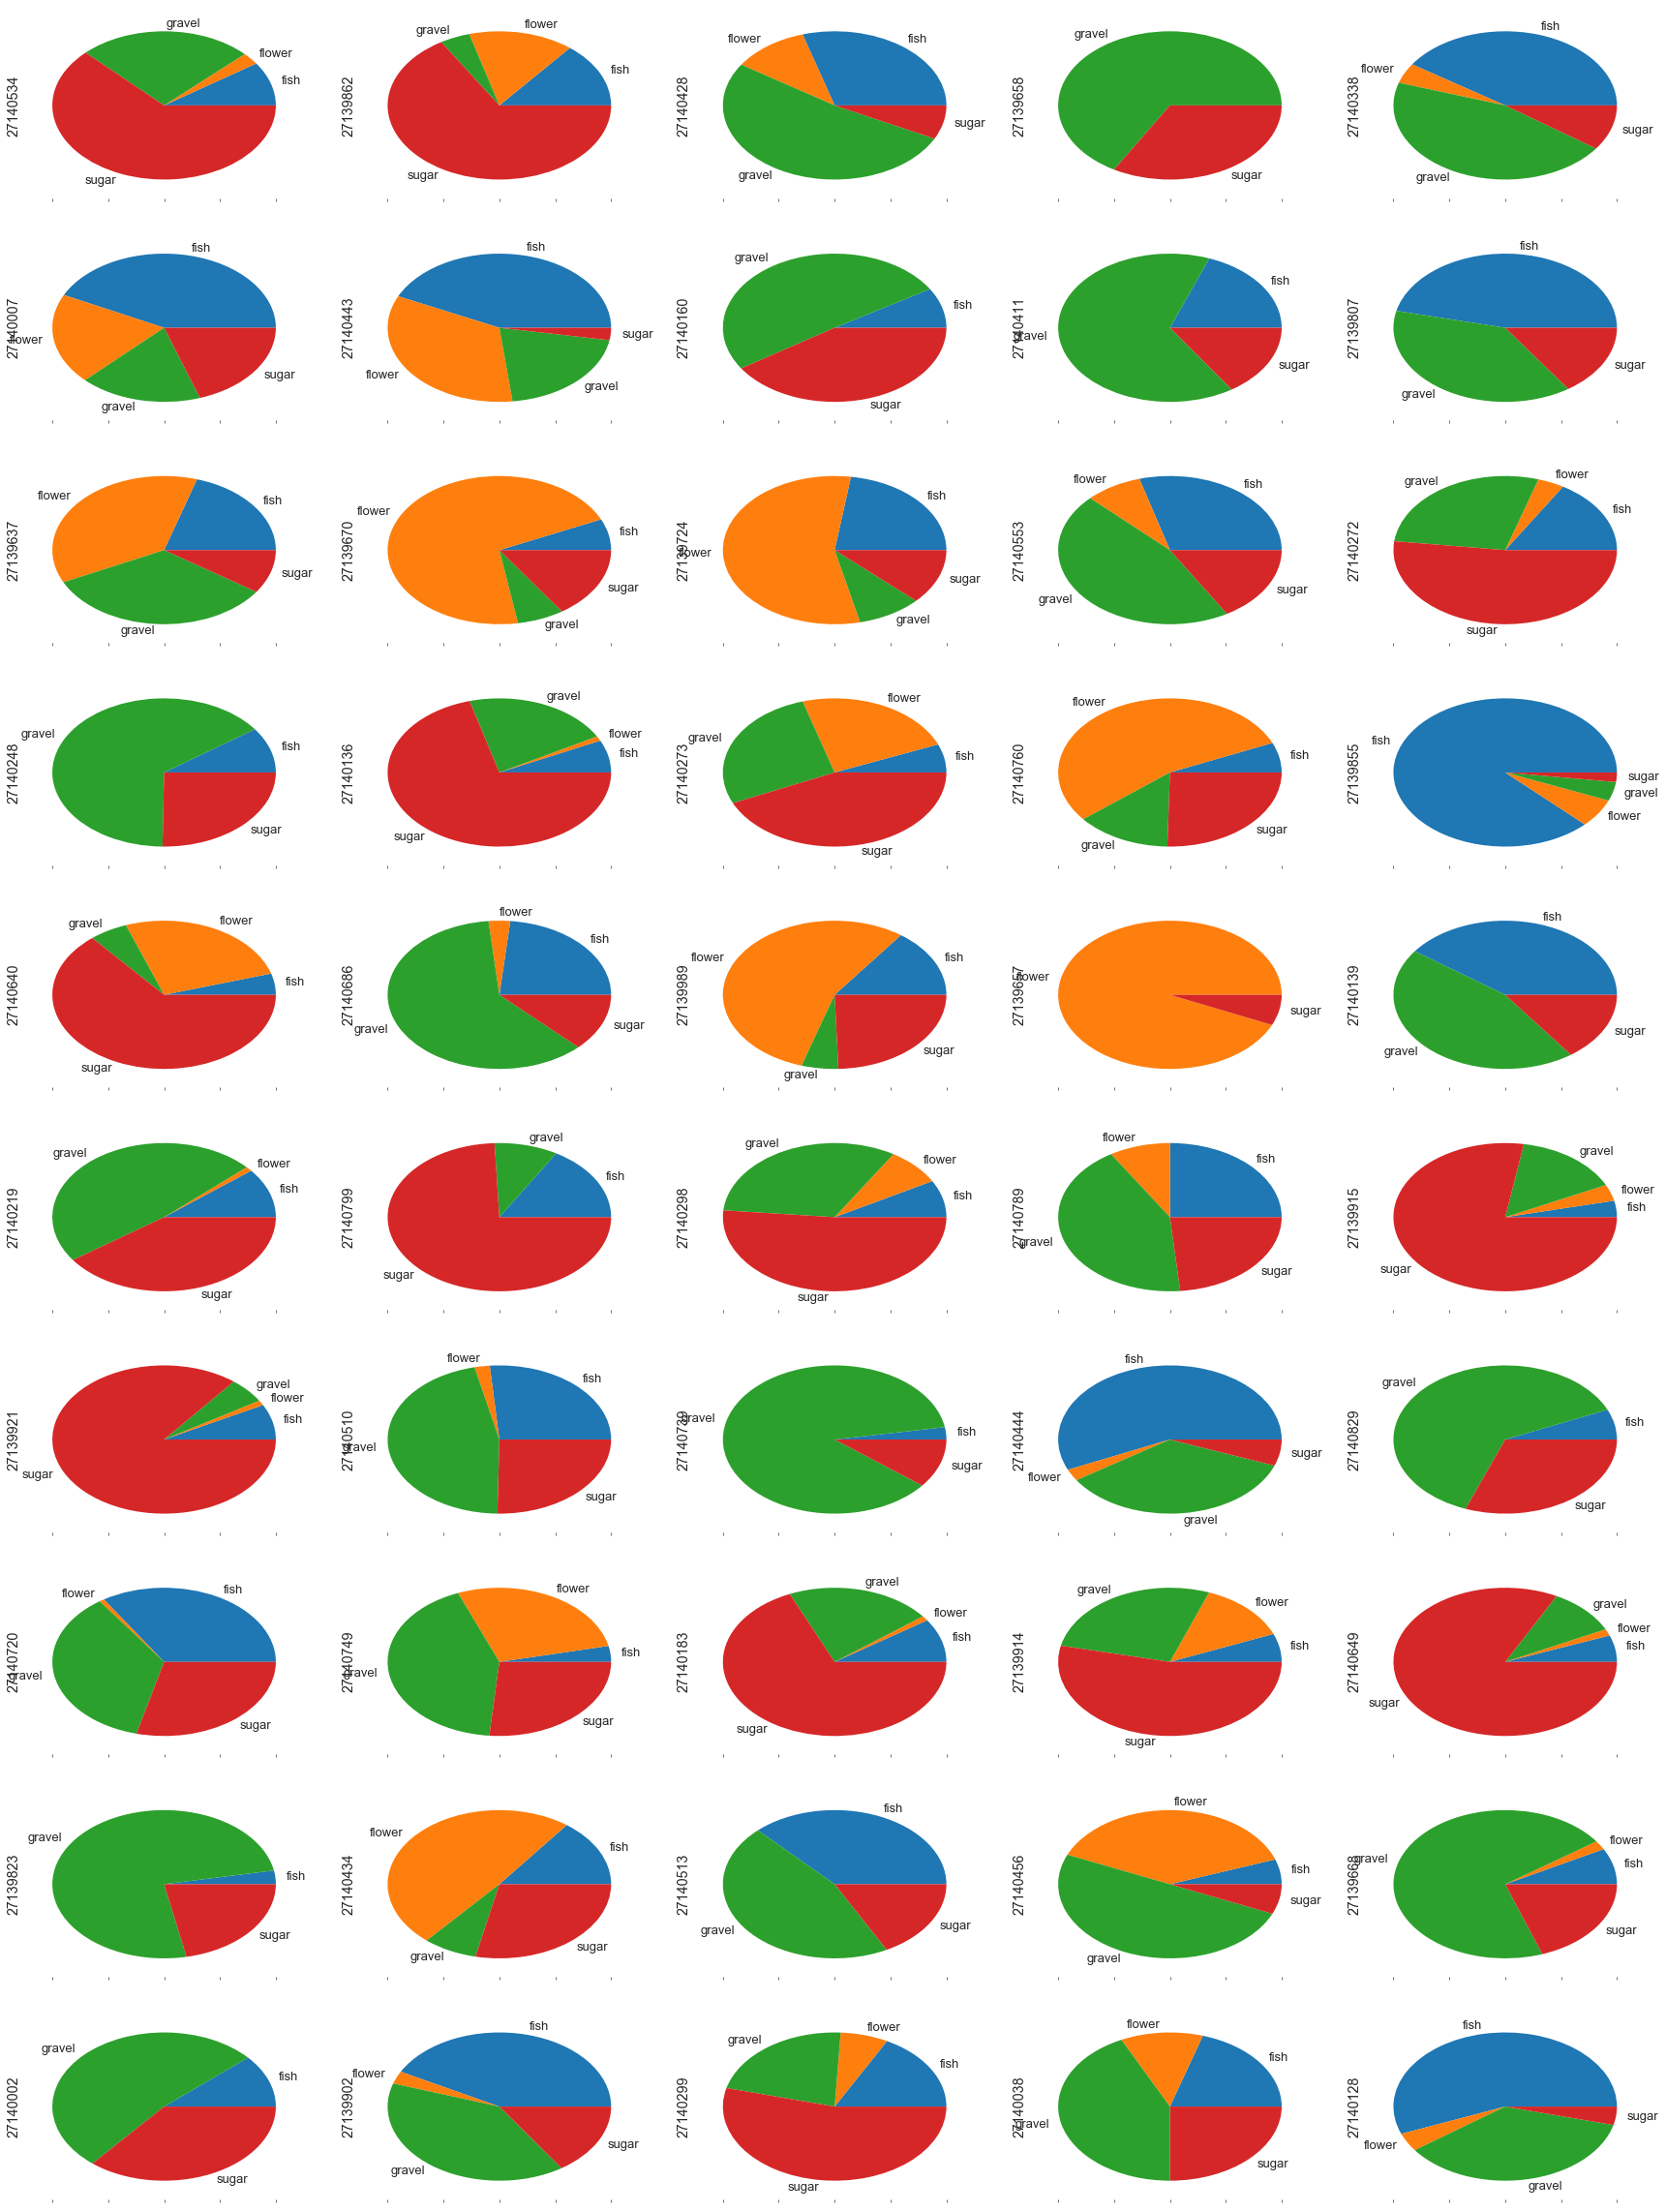

In [41]:
p=practical_image_DF.plot(kind='pie',layout=(12,5), legend=None, subplots=True,figsize=(30,50));

In [ ]:
cla